## Comparison between 2015-6 Boston Marathon results

Held in April each year, the Boston Marathon holds the title of "longest running marathon" in the US, dating back to 1896.

It has been increasingly difficult to enter the race as a qualifier, due to the time standards, overwhelming demand, and a limited number of spots. For those who qualify, register, and beat the "cutoff" on top of the qualification times, running the race often takes a backseat to enjoying the race weekend, or looking forward to Patriot's Day during the interminable months leading up to the event.

Weather plays a big role in how well people run, and it wasn't ideal in 2015, with rain and headwind, or 2016, when starting temperatures pushed up near 70 degrees F. This provides a good opportunity to look at the results in both years and see how people fared in different sub-optimal conditions. One would expect many of the same runners who ran 2015 Boston to return in 2016. Even though one can't assume that "dual finishers" were in the same physical condition for both races, it's worth looking at their approach to pacing themselves on a tough course in different types of bad weather.

To do the analysis, one needs 3 types of data:
1. Entrants list: __[2015](http://registration.baa.org/2015/cf/Public/iframe_EntryLists.cfm)__, __[2016](http://registration.baa.org/2016/cf/Public/iframe_EntryLists.cfm)__
2. Timing details (unofficial): __[2015](http://boston.r.mikatiming.de/2015/)__, __[2016](http://boston.r.mikatiming.de/2016/)__
3. __[Official results](http://registration.baa.org/cfm_Archive/iframe_ArchiveSearch.cfm)__

I scraped the data and included them as XLSX file in the same repository as this notebook file.

I have also written __[blog](https://dunkemo.wordpress.com/2017/08/03/benjamin-button-at-the-120th-boston-marathon/)__ __[posts](https://dunkemo.wordpress.com/2017/08/14/examples-of-pacing-good-bad/)__ about Boston and marathon pacing in general. They might be worth reading to get some background on the race, and understand the types of things I look for when analyzing races: whether people go "hard" for BQs, run faster in the second half, fade down the stretch, or take it "easy" (relatively speaking).


In [1]:
marDist = 26.21875 # marathon distance in miles
fiveK = 3.106856 # 5 kilometers in miles
halfDist = 0.5*marDist # half marathon distance in miles

mats = [fiveK, fiveK*2, fiveK*3, fiveK*4, halfDist, fiveK*5, fiveK*6, fiveK*7, fiveK*8, marDist]

timingmats = {}
for i in range(len(mats)):
    timingmats.update({i+1:mats[i]})

findhalf = [abs(x - 0.5*marDist) for x in mats]
halfway_index = (findhalf.index(min(findhalf))) # 1 if 'split2_time', 2 if 'split3_time', etc
halfway = "split" + str(halfway_index+1) + "_time"
findtenK = [abs(x - fiveK*2) for x in mats]
tenK_index = (findtenK.index(min(findtenK)))
tenK = "split" + str(tenK_index+1) + "_time"
print(tenK)
print(halfway)

split2_time
split5_time


In [2]:
# import modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import re
import unicodedata
from helperFunctions import BQlookup2, get_sec, get_time, getDivision, addColumns2, raceFullStats_DF

### Data import

Let's start by importing 2015's data.

From the entrants list, we'll remove all the wheelchair & handcrank athletes so that we're focusing solely on runners.

An important note about these data sets is that the *bib* values are formatted as __strings__, not integers, since the elite women have "F" in their bib numbers: F1, F2, etc.

In theory, the *bib* column could be used as an index, since no two runners (in a given year) will share the same bib number. But we chose to keep things simple and not reindex.

In [3]:
bos15off = pd.read_excel("2015bostonofficial_20170524.xlsx")
bos15det = pd.read_excel("2015bostondetails.xlsx")
bos15ent = pd.read_excel("2015bostonentrants.xlsx")
# remove all entrants that aren't runners (remove wheelchair & handcrank athletes)
bos15ent = bos15ent[~bos15ent.special.apply(str).str.contains("WC|HC")]

# the details file has different bib numbers for a few people
# we'll change those bib numbers to what's shown in the entrants file
bos15det.bib.replace('5997','5368',inplace=True) # Bell, David
bos15det.bib.replace('5994','3469',inplace=True) # Braunshausen, Andy
bos15det.bib.replace('13995','14840',inplace=True) # Dowd, Bridget
bos15det.bib.replace('5996','3136',inplace=True) # Hallgren, Krister
bos15det.bib.replace('21995','20399',inplace=True) # Harris, Rebecca
bos15det.bib.replace('13994','14381',inplace=True) # Kenutis, Sarah
bos15det.bib.replace('21994','18447',inplace=True) # Kreutz, Wendi
bos15det.bib.replace('21993','19783',inplace=True) # Marshall, Julie
bos15det.bib.replace('25994','29027',inplace=True) # Sheeleigh, Matthias
bos15det.bib.replace('5995','4411',inplace=True) # Suarez Arias, Miguel
bos15det.bib.replace('25995','24077',inplace=True) # Williamson, Delwyn

print("{} (timing details)".format(len(bos15det)))
print("{} (entrants)".format(len(bos15ent)))
print("{} (official)".format(len(bos15off)))

30252 (timing details)
30251 (entrants)
26598 (official)


As datasets go, the 3 files for each year (entrants, timing details, official) all contain essential and necessary information, but they each have their weaknesses --

-  Entrants list: has ages and residence and wave/corral, but doesn't have timing info
-  Timing details: has splits and time-of-day info for runners at all timing mats, but "unofficial"; doesn't have ages and residence and wave/corral
-  Official results: has "official" splits and finish times, ages and residence, but doesn't have wave/corral and doesn't include non-finishers

Still, as long as we know how the files complement each other, we can do merges/joins to create dataframes that include all the info that we want to work with.

Let's continue and add some columns to *bos15off* and calculate metrics.

In [4]:
bos15off = addColumns2(bos15off, 'chip','sex','age', True, mats)

26598 records
25.8170298885 (median stdpace)
7:35 (median splits)


/Users/donwang/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [5]:
# Entrants list doesn't have finish times
# Detailed results don't have wave_corral and exact ages
# so, let's merge the two

df15 = pd.merge(bos15ent, bos15det, on='bib')
print(len(df15))
print(df15['race_state'].value_counts())

30251
finished       26614
not started     3078
started          559
Name: race_state, dtype: int64


By merging the entrants list with the timing details, we can find out not only how people ran, but which people didn't even start.

With the increasing demand for a limited number of Boston spots, thousands of runners register but get rejected each year. For 2015, the BQ cutoff was __[-1:02](http://www.baa.org/news-and-press/news-listing/2014/september/2015-boston-marathon-qualifier-acceptances.aspx)__, and 1947 who beat their BQ requirement by -1:01 to 0:00 were left out.

It's also a fact of life that not everyone who gets in will start, and not everyone who starts will finish. In 2015, 3078 didn't start the race due to various reasons: injury, life events, disqualification, etc.

Because people are upset about not getting in, they look for people to blame, and that's why charity runners often draw the ire of would-be entrants. So, the question should be asked: if registrants don't even start, which wave-corrals do these DNSers come from? Are charity runners more or less likely to let a spot go to waste?

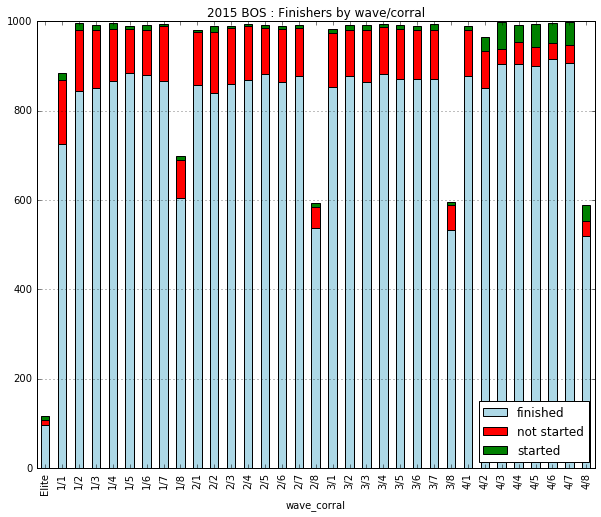

In [6]:
# finishers / non-starters / starters by wave_corral

finishers = pd.pivot_table(df15, columns='race_state', values='bib', index ='wave_corral', aggfunc=len)
finishers = finishers.reindex(['Elite'] + list(finishers.index[0:-1]))
finishers.plot(kind='bar', stacked=True, color=['lightblue','red','green'], figsize=(10,8))
plt.grid(which='both',axis='y')
plt.title("2015 BOS : Finishers by wave/corral")
plt.legend(loc='lower right')
plt.show()
# red portions represent DNSers; charity runners have lower DNS rates than qualifiers
# green portions represent those who didn't finish before 5:XX PM; not necessarily all dropped out

Charity runners are put toward the back from Wave/corral 4/3 onward.

We can clearly see that non-charity runners take DNSs at a higher rate than charity runners.

In [7]:
# merge unofficial results with official results (left join)
bos15merge = pd.merge(df15, bos15off, on=['bib'], how='left')
print(len(bos15merge))

30251


#### Preliminary exploratory data analysis

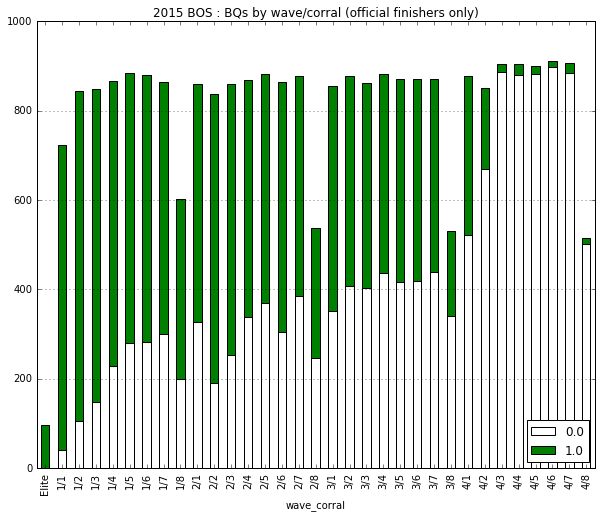

In [8]:
# BQs by wave_corral

finishers15 = pd.pivot_table(bos15merge, columns='BQ', values='bib', index ='wave_corral', aggfunc=len)
finishers15 = finishers15.reindex(['Elite'] + list(finishers15.index[0:-1]))
finishers15.plot(kind='bar', stacked=True, color=['white','green'], figsize=(10,8))
plt.grid(which='both',axis='y')
plt.title("2015 BOS : BQs by wave/corral (official finishers only)")
plt.legend(loc='lower right')
plt.show()

##### Chip vs bib

Attribution: https://www.runnersworld.com/boston-marathon/dozens-suspected-of-cheating-to-enter-boston-marathon

Plotting chip times by bib # will show outliers in the results.

For the most part, runners are seeded by bib #, meaning that the faster the runner, the lower the bib #. (Charity runners are given high bib #s and are placed at the back in Wave 4. They have varying degrees of running ability, as shown in the plot below.)

So, if fast runners record slow times and slow runners record fast times, then those points will stick out.

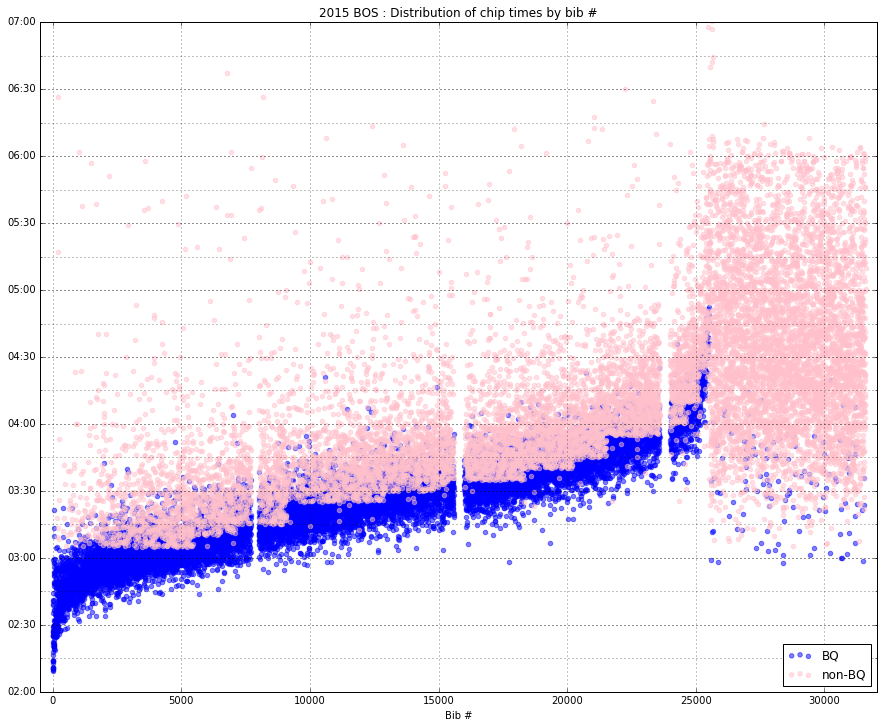

In [9]:
fig, ax = plt.subplots(1,1, figsize=(15,12))
plt.scatter(bos15merge.query("BQ==1").bib.str.replace("F","").apply(int), bos15merge.query("BQ==1").epoch, alpha=0.5, label='BQ', color='b')
plt.scatter(bos15merge.query("BQ==0").bib.str.replace("F","").apply(int), bos15merge.query("BQ==0").epoch, alpha=0.5, label='non-BQ', color='pink')

ax.yaxis.set_major_locator(mdates.HourLocator())
ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ylocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.yaxis.set_minor_locator(ylocator)
ax.yaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
plt.xticks(rotation=0)
plt.grid(which='both',axis='both')
plt.legend(loc='lower right')
plt.title("2015 BOS : Distribution of chip times by bib #")
plt.xlim([-500, bos15merge.query("BQ==1").bib.str.replace("F","").apply(int).max()+500])
plt.ylim([mdates.epoch2num(60*60*2), mdates.epoch2num(60*60*7)])
plt.xlabel("Bib #")
plt.show()

This type of plot helps to identify outliers. We can clearly see runners from Waves 1-4 with the narrow spaces of unused bibs between the waves. Charity runners start toward the back, from Wave 4, Corral 3 onward, and we can the large variation in running ability on the far right.

We've plotted the blue BQ dots first, with the pink non-BQ dots laid on top, so it might be difficult in some cases to see the BQs underneath. Making the plot in Tableau or D3.js, with their tooltip capabilities and additional flexibility, would add a lot of value to this type of visualization.

In [10]:
pd.set_option('max_colwidth',120)

bos15stats = raceFullStats_DF(bos15off,'sex','age')
bos15stats

,#_run,#_BQs,BQ%,BQ_time,Min_time,Med_time,Mean_time,Max_time
Age_Group,,,,,,,,
F0-34,4144,1880,45.4%,3:35,2:24:55,3:38:43,3:53:14,6:08:02
F35-39,1860,936,50.3%,3:40,2:38:47,3:40:52,3:51:08,6:26:29
F40-44,1984,977,49.2%,3:45,2:48:28,3:46:43,3:55:58,6:17:23
F45-49,1832,983,53.7%,3:55,2:46:44,3:54:14,4:01:14,6:42:01
F50-54,1206,642,53.2%,4:00,2:52:51,3:59:25,4:06:10,6:06:44
F55-59,607,319,52.6%,4:10,2:54:03,4:09:50,4:16:00,6:07:50
F60-64,270,150,55.6%,4:25,3:12:51,4:22:31,4:28:28,7:51:30
F65-69,91,43,47.3%,4:40,3:39:34,4:45:01,4:47:52,7:59:33
F70-74,20,11,55.0%,4:55,4:00:56,4:51:57,4:52:07,5:57:40


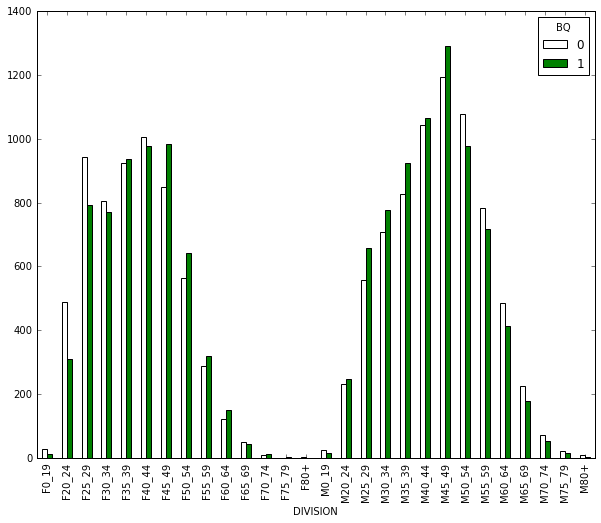

In [11]:
# plot histogram of AGs & BQs
AGbqs = pd.pivot_table(bos15off, columns='BQ', values='bib', index ='DIVISION', aggfunc=len)
AGbqs.plot(kind='bar',stacked=False,color = ['white','green'], figsize=[10,8])
plt.show()

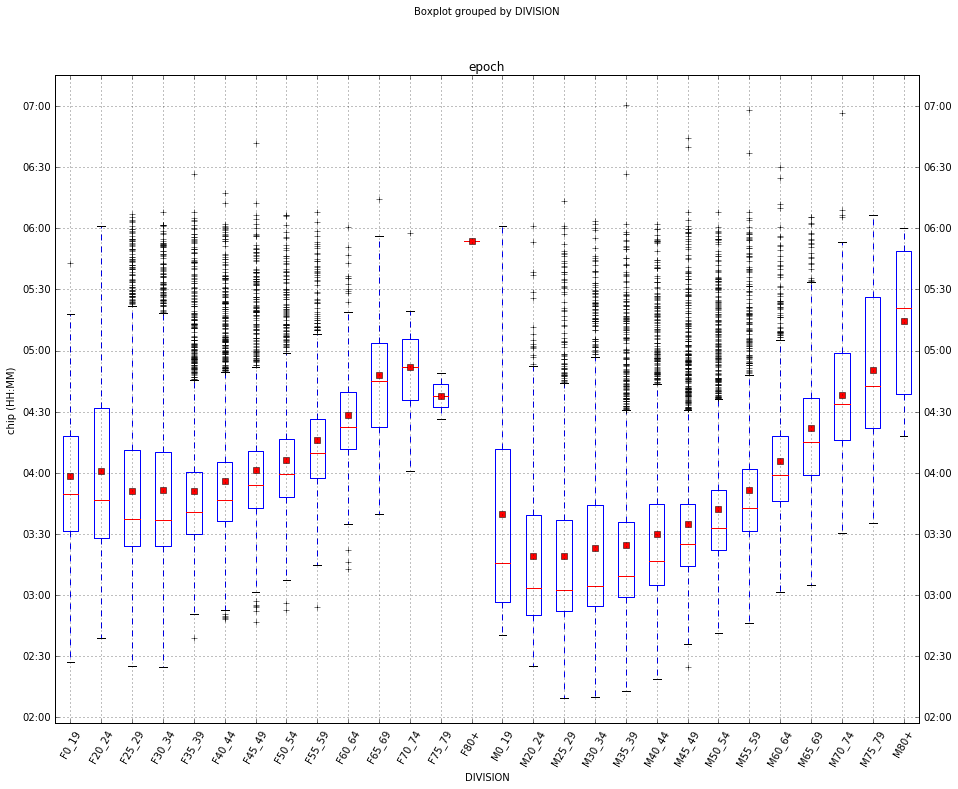

In [12]:
dfr = bos15off
ax = dfr.boxplot(column='epoch',by='DIVISION',figsize=[15,12],rot=60, showmeans=True)
yformatter = mdates.DateFormatter('%H:%M')
ylocator = mdates.MinuteLocator(byminute=[0,30], interval = 1)

## Set ytick labels to appear every 30 minutes
ax.yaxis.set_major_locator(ylocator)
ax.tick_params(labeltop=False, labelright=True)

## Format ytick labels as HH:MM
plt.gcf().axes[0].yaxis.set_major_formatter(yformatter)
plt.ylabel('chip (HH:MM)')
plt.ylim([mdates.epoch2num(60*60*1.95),mdates.epoch2num(60*60*7.25)])
plt.show()

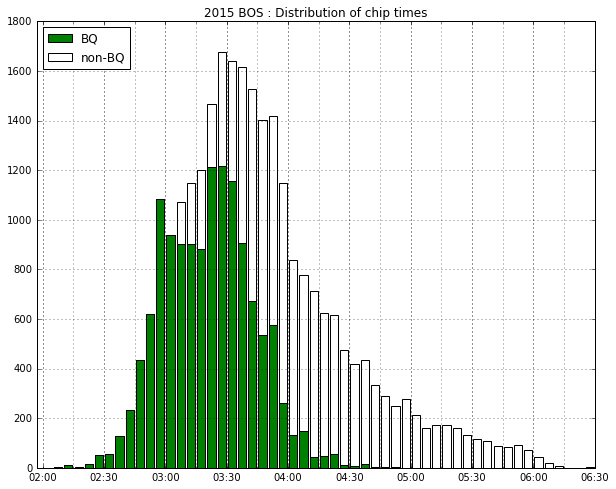

In [13]:
# plot histogram of finish times, with bin sizes of 5 minutes !!

dfr = bos15off

fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.hist([dfr[(dfr.BQ==1)]['epoch'],dfr[(dfr.BQ==0)]['epoch']], 
    bins=mdates.epoch2num(np.arange(60*60*1.5,60*60*8,60*5)), 
    stacked=True, color = ['green','white'], histtype='bar',align='mid',label=['BQ','non-BQ'])
ymax = max(ax.get_ylim())
xmax = 60*60*6.5#dfr.seconds.max() + 60*10

ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
xlocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.xaxis.set_minor_locator(xlocator)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
plt.xticks(rotation=0)
plt.grid(which='both',axis='both')
plt.legend(loc='upper left')
plt.title("2015 BOS : Distribution of chip times")
plt.xlim([mdates.epoch2num(60*60*1.95),mdates.epoch2num(xmax)])
plt.show()

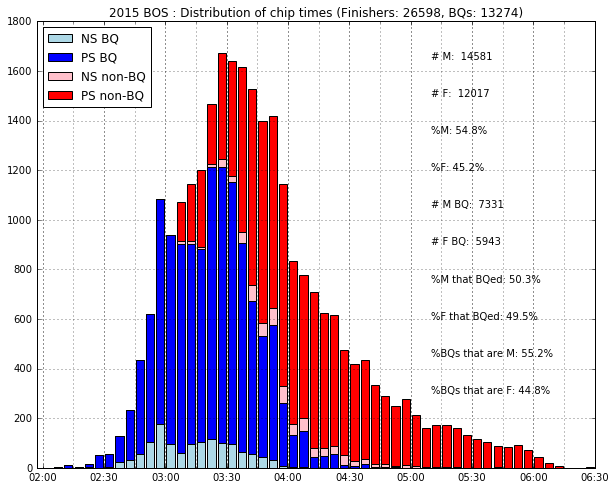

In [14]:
# show histogram in terms of NS/PS

dfr = bos15off

fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.hist([dfr[(dfr.BQ==1) & (dfr.splits<0)]['epoch'],dfr[(dfr.BQ==1) & (dfr.splits>=0)]['epoch'],dfr[(dfr.BQ==0) & (dfr.splits<0)]['epoch'],dfr[(dfr.BQ==0) & (dfr.splits>=0)]['epoch']], 
         bins=mdates.epoch2num(np.arange(60*60*1.5,60*60*8,60*5)), stacked=True, color = ['lightblue','blue','pink','red'], histtype='bar',align='mid',label=['NS BQ','PS BQ','NS non-BQ', 'PS non-BQ'])
ymax = max(ax.get_ylim())
xmax = 60*60*6.5#dfr.seconds.max() + 60*10
lines_of_text = 12

ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
xlocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.xaxis.set_minor_locator(xlocator)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
plt.xticks(rotation=0)
plt.grid(which='both',axis='both')
plt.legend(loc='upper left')
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-1),"# M:  " + str(len(dfr[dfr.sex=='M'])))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-2),"# F:  " + str(len(dfr[dfr.sex=='F'])))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-3),"%M: {:.1%}".format(len(dfr[(dfr.sex=='M')])*1.0/len(dfr)))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-4),"%F: {:.1%}".format(len(dfr[(dfr.sex=='F')])*1.0/len(dfr)))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-5),"# M BQ:  " + str(len(dfr[(dfr.sex=='M') & (dfr.BQ==1)])))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-6),"# F BQ:  " + str(len(dfr[(dfr.sex=='F') & (dfr.BQ==1)])))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-7),"%M that BQed: {:.1%}".format(len(dfr[(dfr.sex=='M') & (dfr.BQ==1)])*1.0/len(dfr[dfr.sex=='M'])))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-8),"%F that BQed: {:.1%}".format(len(dfr[(dfr.sex=='F') & (dfr.BQ==1)])*1.0/len(dfr[dfr.sex=='F'])))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-9),"%BQs that are M: {:.1%}".format(len(dfr[(dfr.sex=='M') & (dfr.BQ==1)])*1.0/len(dfr[dfr.BQ==1])))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-10),"%BQs that are F: {:.1%}".format(len(dfr[(dfr.sex=='F') & (dfr.BQ==1)])*1.0/len(dfr[dfr.BQ==1])))
plt.title("2015 BOS : Distribution of chip times (Finishers: " + str(len(dfr)) + ", BQs: " + str(len(dfr.query("BQ==1"))) + ")")
plt.xlim([mdates.epoch2num(60*60*1.95),mdates.epoch2num(xmax)])
plt.show()

In [15]:
# negative split BQs
columns_i_want = ['BQ','bib', 'name', 'age','chip',halfway,'2ndhalf','splits','mm','non_missing_splitpaces_time']
nsbq15 = dfr[(dfr.BQ==1) & (dfr.splits < 0)]
print(len(nsbq15))
print(nsbq15['sex'].value_counts())
(nsbq15[columns_i_want].sample(10))

1279
M    725
F    554
Name: sex, dtype: int64


,BQ,bib,name,age,chip,split5_time,2ndhalf,splits,mm,non_missing_splitpaces_time
7804,1,13979,"Berke, Stuart A.",54,3:22:53,1:41:48,1:41:05,-43.0,[],"[7:53, 7:40, 7:45, 7:48, 7:39, 7:45, 7:49, 7:49, 7:36, 7:26]"
5514,1,7584,"Balistreri, Theodore",48,3:13:52,1:37:48,1:36:04,-104.0,[],"[7:28, 7:36, 7:23, 7:22, 7:33, 7:20, 7:25, 7:23, 7:09, 7:24]"
8428,1,12888,"Torgersen, Eric",53,3:24:52,1:42:44,1:42:08,-36.0,[],"[7:49, 7:50, 7:52, 7:51, 7:45, 7:50, 7:55, 7:51, 7:38, 7:40]"
2423,1,5366,"Trussas, Peter J",44,2:59:10,1:31:13,1:27:57,-196.0,[],"[7:07, 6:54, 6:52, 6:57, 6:55, 6:46, 6:53, 6:48, 6:31, 6:26]"
2270,1,5497,"Glynn, Scott",44,2:58:36,1:29:22,1:29:14,-8.0,[],"[7:01, 6:42, 6:46, 6:48, 6:43, 6:45, 6:50, 6:54, 6:48, 6:39]"
2387,1,4945,"Torguson, Erik R",32,2:59:01,1:29:45,1:29:16,-29.0,[],"[6:57, 6:49, 6:44, 6:51, 6:56, 6:53, 7:01, 6:57, 6:39, 6:15]"
2990,1,4700,"Yovichin, Al",52,3:01:49,1:32:16,1:29:33,-163.0,[],"[7:48, 6:48, 6:48, 6:49, 6:43, 6:51, 7:00, 7:01, 7:05, 5:24]"
14436,1,22207,"Kickels, Christine",47,3:43:18,1:53:09,1:50:09,-180.0,[],"[8:51, 8:31, 8:34, 8:35, 8:41, 8:35, 8:22, 8:19, 8:18, 8:34]"
814,1,1391,"Hall, Kyle",20,2:48:54,1:25:14,1:23:40,-94.0,[],"[6:25, 6:35, 6:29, 6:34, 6:18, 6:26, 6:30, 6:30, 6:14, 6:04]"
1400,1,3228,"Popa, Cristian",45,2:54:00,1:27:34,1:26:26,-68.0,[],"[6:47, 6:39, 6:38, 6:39, 6:34, 6:37, 6:40, 6:41, 6:29, 6:26]"


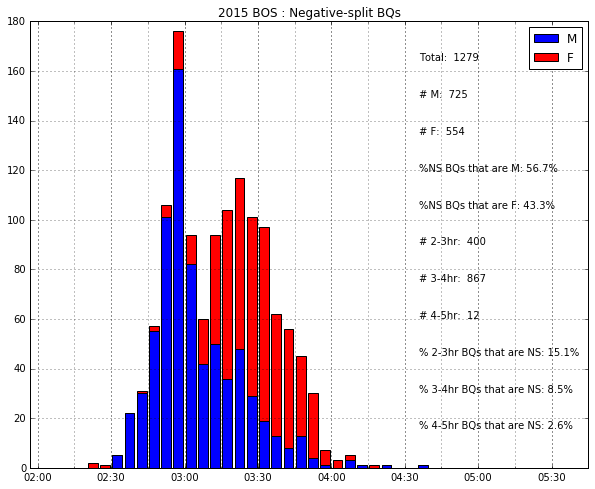

In [16]:
# plotting NS BQs
fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.hist([nsbq15.query("sex=='M'")['epoch'],nsbq15.query("sex=='F'")['epoch']], 
         bins=mdates.epoch2num(np.arange(60*60*1.5,60*60*5.5,60*5)), stacked=True, color = ['blue','red'], histtype='bar',align='mid',label=['M','F'])
ymax = max(ax.get_ylim())
lines_of_text = 12
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-1),"Total:  " + str(len(nsbq15)))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-2),"# M:  " + str(len(nsbq15[nsbq15.sex=='M'])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-3),"# F:  " + str(len(nsbq15[nsbq15.sex=='F'])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-4),"%NS BQs that are M: {:.1%}".format(len(nsbq15[nsbq15.sex=='M'])*1.0/len(nsbq15)))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-5),"%NS BQs that are F: {:.1%}".format(len(nsbq15[nsbq15.sex=='F'])*1.0/len(nsbq15)))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-6),"# 2-3hr:  " + str(len(nsbq15[nsbq15.seconds.isin(range(60*60*2,60*60*3))])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-7),"# 3-4hr:  " + str(len(nsbq15[nsbq15.seconds.isin(range(60*60*3,60*60*4))])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-8),"# 4-5hr:  " + str(len(nsbq15[nsbq15.seconds.isin(range(60*60*4,60*60*5))])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-9),"% 2-3hr BQs that are NS: {:.1%}".format(len(nsbq15[nsbq15.seconds.isin(range(60*60*2,60*60*3))])*1.0/len(dfr[dfr.seconds.isin(range(60*60*2,60*60*3)) & (dfr.BQ==1)])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-10),"% 3-4hr BQs that are NS: {:.1%}".format(len(nsbq15[nsbq15.seconds.isin(range(60*60*3,60*60*4))])*1.0/len(dfr[dfr.seconds.isin(range(60*60*3,60*60*4)) & (dfr.BQ==1)])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-11),"% 4-5hr BQs that are NS: {:.1%}".format(len(nsbq15[nsbq15.seconds.isin(range(60*60*4,60*60*5))])*1.0/len(dfr[dfr.seconds.isin(range(60*60*4,60*60*5)) & (dfr.BQ==1)])))
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
xlocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.xaxis.set_minor_locator(xlocator)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
plt.grid(which='both',axis='both')
plt.legend()
plt.title("2015 BOS : Negative-split BQs")
plt.xlim([mdates.epoch2num(60*60*1.95),mdates.epoch2num(60*60*5.75)])
plt.show()

Anecdotally, women are often thought to be better at starting races conservatively and being smart about conserving energy for a strong finish.

But the above shows that most NS BQs at 2015 Boston were run by men.

It's important to put the numbers into context, though. The previous histogram showed that there were more male finishers (54.8% men compared to 45.2%), and men made up 55.2% of the BQs.

So, while men took up 56.7% of the NS BQs, this was only slightly higher than their "fair share" of 55.2%. In other words, we shouldn't compare 56.7% to 50% (50/50 male/female), but rather 55.2%.

We'll run the NS BQ numbers for 2016 later on.

In [17]:
# These are the people who had their unofficial times adjusted
columns_i_want = ['BQ','bib','name_x','age_x','city_x','chip_x','chip_y','diff_t']
bos15merge.assign(diff=lambda x: (x.chip_y.apply(get_sec)-x.chip_x.apply(get_sec)))\
    .assign(diff_t=lambda x: x['diff'].apply(get_time))[(bos15merge.chip_x.apply(get_sec)!=bos15merge.chip_y.apply(get_sec)) & (bos15merge.chip_x.notnull() & bos15merge.chip_y.notnull())].sort_values(by='diff')[columns_i_want]
# here, chip_x represents unofficial chip time, and chip_y represents official chip time

,BQ,bib,name_x,age_x,city_x,chip_x,chip_y,diff_t
26451,0.0,30533,"Sunderland, Jake",37,Taunton,04:27:18,4:19:55,-7:23
22090,0.0,30879,"Raamat, Rasmus",31,Tueri,04:13:14,4:05:59,-7:15
17795,0.0,15001,"McGuire, Tim",54,Oakville,04:03:29,3:56:19,-7:10
20610,1.0,30877,"Palmer, Andy",30,Auckland,03:08:40,3:01:34,-7:06
3950,0.0,14729,"Caruso, Alison H.",37,Bolton,04:12:33,4:06:23,-6:10
4850,0.0,29401,"Cohn, Dianne",67,Sacramento,05:49:03,5:43:03,-6:00
25633,0.0,23302,"Spaulding, Jennifer",45,Scituate,04:16:39,4:10:41,-5:58
25429,0.0,23113,"Sneshkoff, Ted",61,Wellsboro,04:05:45,3:59:50,-5:55
6699,0.0,30938,"Diks, Marc",44,Ijsselstein,03:57:57,3:52:14,-5:43
974,1.0,7192,"Back, Harry J Jr.",45,Endicott,03:17:17,3:11:58,-5:19


In [18]:
# These are the people who wouldn't have BQed had their unofficial times not been adjusted
columns_i_want = ['BQ','bib','name_x','age_x','city_x','BQreq','chip_x','chip_y','diff_t']
bos15merge.assign(diff=lambda x: (x.chip_y.apply(get_sec)-x.chip_x.apply(get_sec)))\
    .assign(diff_t=lambda x: x['diff'].apply(get_time))\
    [(bos15merge.chip_x.apply(get_sec)!=bos15merge.chip_y.apply(get_sec)) 
    & (bos15merge.chip_x.notnull() & bos15merge.chip_y.notnull()) 
    & (bos15merge.chip_x.apply(get_sec) > bos15merge.BQreq.apply(get_sec)) 
    & (bos15merge.BQ==1)].sort_values(by='diff')[columns_i_want]

,BQ,bib,name_x,age_x,city_x,BQreq,chip_x,chip_y,diff_t
20610,1.0,30877,"Palmer, Andy",30,Auckland,3:05:00,03:08:40,3:01:34,-7:06
29604,1.0,7171,"Wong, Steven S",40,Mountain View,3:15:00,03:19:21,3:14:13,-5:08
2326,1.0,19369,"Boley, Amber M",35,Murphy,3:40:00,03:41:06,3:38:24,-2:42


In [19]:
# These are the people who didn't have an "unofficial" time but had an official time
columns_i_want = ['BQ','bib','name_x','age_x','race_state','last_split','chip_x','chip_y','mm','non_missing_splitpaces_time']
bos15merge[bos15merge.chip_x.isnull() & bos15merge.chip_y.notnull()][columns_i_want]

,BQ,bib,name_x,age_x,race_state,last_split,chip_x,chip_y,mm,non_missing_splitpaces_time
438,0.0,1360,"Ames, Zachary",43,started,40K,NaN,3:19:07,[],"[5:55, 6:19, 6:31, 6:30, 6:24, 6:35, 6:47, 7:04, 11:12, 16:28]"
3876,0.0,31506,"Carr, Lucas S.",35,started,25K,NaN,3:38:32,"[7, 8, 9]","[7:01, 7:56, 8:24, 8:59, 8:42, 11:06, 7:59]"
5284,0.0,28027,"Cosgrove, Rita B.",54,started,40K,NaN,6:06:29,[],"[11:37, 12:14, 13:00, 13:58, 13:09, 15:03, 15:23, 15:21, 15:39, 13:59]"
7678,0.0,8007,"Emilio, Dave",47,not started,NaN,NaN,3:38:45,"[1, 2, 3, 4, 5, 6, 7, 8, 9]",[8:21]
7874,0.0,14906,"Evans, Sarah L",31,started,40K,NaN,3:37:07,"[1, 2, 3, 5, 6, 7, 8]","[8:15, 8:15, 8:49]"
8981,1.0,4535,"Fulton, Max",38,started,20K,NaN,3:06:23,"[1, 2, 3, 5, 6, 7, 8, 9]","[6:54, 7:17]"
10239,0.0,16379,"Greenfield, Leslie R",29,not started,NaN,NaN,3:58:22,"[1, 2, 3, 4, 5, 6, 7, 8, 9]",[9:05]
12958,0.0,12449,"Jaquith, Eric D",47,started,40K,NaN,4:38:00,[],"[7:15, 7:13, 7:11, 7:18, 7:23, 7:32, 8:05, 10:53, 21:33, 28:29]"
14755,1.0,8759,"Kubasiak, Anne",37,started,30K,NaN,3:26:14,"[8, 9]","[7:06, 7:27, 7:28, 7:40, 7:39, 8:03, 8:10, 8:26]"
21082,1.0,19104,"Pepin, Megan",43,started,30K,NaN,3:33:40,"[8, 9]","[8:25, 8:04, 8:09, 8:08, 8:08, 8:09, 8:12, 8:04]"


In [20]:
# These are the people who had an "unofficial" time but didn't have an official time
# In other words, they were possibly DQed for one reason or another
columns_i_want = ['bib','name_x','age_x','chip_x','city_x','chip_y','race_state','last_split']
bos15merge[bos15merge.chip_x.notnull() & bos15merge.chip_y.isnull()][columns_i_want]

,bib,name_x,age_x,chip_x,city_x,chip_y,race_state,last_split
71,7141,"Ackermann, Melissa",39,03:34:34,New York,NaN,finished,Finish Net
413,17658,"Alvarez, Gia P",34,03:22:41,Tenafly,NaN,finished,Finish Net
1819,192,"Bergman, Marc J.",35,03:57:39,Austin,NaN,finished,Finish Net
1899,7273,"Bertoia, Julie A",37,06:40:31,Henderson,NaN,finished,Finish Net
2645,26468,"Bradley, Michael J.",62,05:09:45,Acton,NaN,finished,Finish Net
2838,25644,"Briggs, Mark L.",54,,Foxboro,NaN,started,40K
5525,29186,"Crisci, Lynn A.",38,04:53:42,Boston,NaN,finished,Finish Net
7601,8003,"Eldridge, Kim",44,03:32:38,Austin,NaN,finished,Finish Net
7840,31262,"Eteneau, Bertrand",55,03:49:01,St Maure Des Fausses,NaN,finished,Finish Net
8637,9145,"Forrest, Dave",62,03:22:05,Charlotte,NaN,finished,Finish Net


Let's continue with importing 2016's data --

In [21]:
bos16off = pd.read_excel("2016bostonofficial_20170524.xlsx")
bos16det = pd.read_excel("2016bostondetails.xlsx")
bos16ent = pd.read_excel("2016bostonentrants.xlsx")
# remove all entrants that aren't runners (remove wheelchair & handcrank athletes)
bos16ent = bos16ent[~bos16ent.special.apply(str).str.contains("WC|HC")]

# the details file has different bib numbers for a few people
# we'll change those bib numbers to what's shown in the entrants file
bos16det.bib.replace('22990','19399',inplace=True) # Altendorf, Timothy
bos16det.bib.replace('14990','8226',inplace=True) # Calderon, Ramiro
bos16det.bib.replace('15585','15144',inplace=True) # Fox, John
bos16det.bib.replace('32114','30334',inplace=True) # Francis, David
bos16det.bib.replace('4998','3945',inplace=True) # Kositzke, Jacob
bos16det.bib.replace('23599','25448',inplace=True) # Pascua, Luigi
bos16det.bib.replace('19993','19390',inplace=True) # Spence, Steve
bos16det.bib.replace('32115','31323',inplace=True) # Yagoda, Aaron
bos16det.bib.replace('19992','17209',inplace=True) # Yingling, Leah

print("{} (timing details)".format(len(bos16det)))
print("{} (entrants)".format(len(bos16ent)))
print("{} (official)".format(len(bos16off)))

30743 (timing details)
30741 (entrants)
26630 (official)


In [22]:
bos16off = addColumns2(bos16off, 'chip','sex','age',True, mats, False)

26630 records
39.1246884074 (median stdpace)
13:05 (median splits)


In [23]:
# Entrants list doesn't have finish times
# Detailed results don't have wave_corral and exact ages
# so, let's merge the two

df16 = pd.merge(bos16ent, bos16det, on='bib')
print(len(df16))

30741


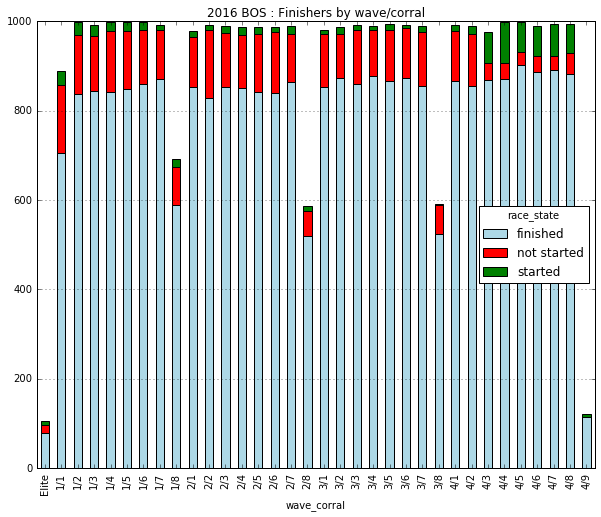

In [24]:
# finishers / non-starters / starters by wave_corral

finishers = pd.pivot_table(df16, columns='race_state', values='bib', index ='wave_corral', aggfunc=len)
finishers = finishers.reindex(['Elite'] + list(finishers.index[0:-1]))
finishers.plot(kind='bar', stacked=True, color=['lightblue','red','green'], figsize=(10,8))
plt.grid(which='both',axis='y')
plt.title("2016 BOS : Finishers by wave/corral")
plt.show()
# red portions represent DNSers; charity runners have lower DNS rates than qualifiers
# green portions represent those who didn't finish before 5:XX PM; not necessarily all dropped out

In [25]:
# merge unofficial results with official results
bos16merge = pd.merge(df16, bos16off, on=['bib'], how='left')
print(len(bos16merge))

30741


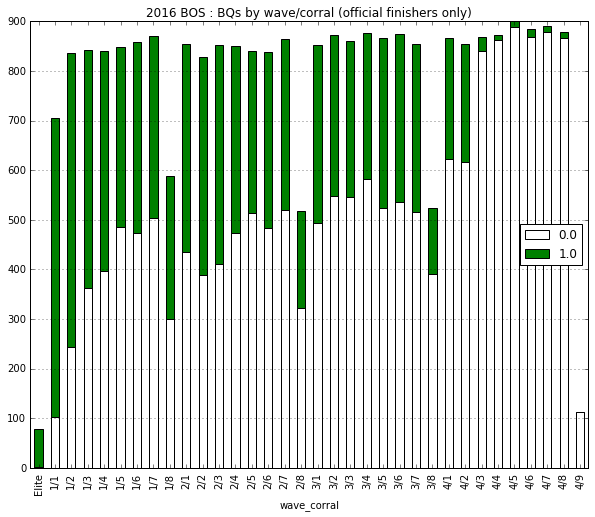

In [26]:
# BQs by wave_corral

finishers16 = pd.pivot_table(bos16merge, columns='BQ', values='bib', index ='wave_corral', aggfunc=len)
finishers16 = finishers16.reindex(['Elite'] + list(finishers16.index[0:-1]))
finishers16.plot(kind='bar', stacked=True, color=['white','green'], figsize=(10,8), layout=())
plt.grid(which='both',axis='y')
plt.title("2016 BOS : BQs by wave/corral (official finishers only)")
plt.legend(loc='center right')
plt.show()

The above looks noticeably different than 2015's version.

Let's plot both 2015-6 side-by-side --

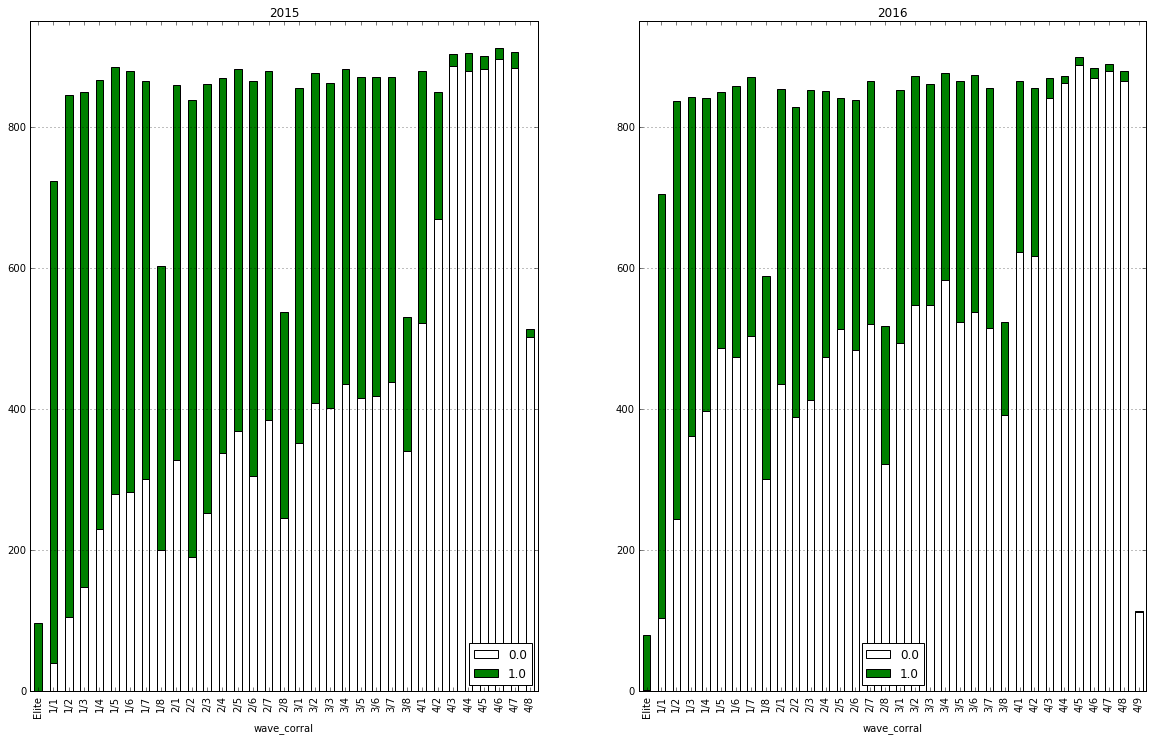

In [27]:
# BQs by wave_corral (comparing 2015-6)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,12))

finishers15.plot(kind='bar', stacked=True, color=['white','green'],ax=axes[0], ylim=(0,950), title='2015')
axes[0].legend(loc='lower right')
finishers16.plot(kind='bar', stacked=True, color=['white','green'],ax=axes[1], ylim=(0,950), title='2016')
axes[1].legend(loc='lower center')
axes[0].grid(which='both',axis='y')
axes[1].grid(which='both',axis='y')
plt.show()

In 2016, it appears that those toward the back of waves 1-3 were more similar to their counterparts in the other waves.

In other words, wave 1/7 fared much better in 2015 than in 2016, in terms of running BQs.

In [28]:
bos16stats = raceFullStats_DF(bos16off,'sex','age')
bos16stats

,#_run,#_BQs,BQ%,BQ_time,Min_time,Med_time,Mean_time,Max_time
Age_Group,,,,,,,,
F0-34,4068,1350,33.2%,3:35,2:29:19,3:47:25,4:00:54,6:43:50
F35-39,1879,701,37.3%,3:40,2:32:28,3:48:35,3:58:26,10:30:23
F40-44,1938,737,38.0%,3:45,2:48:49,3:52:58,4:02:17,6:08:37
F45-49,1901,769,40.5%,3:55,2:51:33,4:01:33,4:08:20,7:47:56
F50-54,1254,533,42.5%,4:00,2:53:30,4:06:50,4:13:12,6:58:53
F55-59,650,254,39.1%,4:10,3:21:41,4:17:31,4:23:53,6:03:37
F60-64,346,147,42.5%,4:25,3:17:22,4:30:20,4:34:27,6:12:20
F65-69,101,45,44.6%,4:40,3:39:01,4:45:39,4:45:36,6:00:07
F70-74,27,9,33.3%,4:55,4:00:40,5:09:28,5:08:57,5:54:06


We won't repeat much of the EDA for 2016 that we did for 2015 (age-group histograms, boxplots, etc).

But it's worth showing the negative-split numbers: there were a lot fewer NS BQs in 2016, but most of those were women.

Perhaps there *is* some truth to women starting more conservatively than men, especially in hot weather! (We'll do some more comparisons between men & women later on.)

In [29]:
# negative split BQs for 2016
columns_i_want = ['BQ','bib', 'name', 'age','chip',halfway,'2ndhalf','splits','mm','non_missing_splitpaces_time']
dfr = bos16off
nsbq16 = dfr[(dfr.BQ==1) & (dfr.splits < 0)]
print(len(nsbq16))
print(nsbq16['sex'].value_counts())
print(nsbq16['sex'].value_counts(normalize=True))

383
F    228
M    155
Name: sex, dtype: int64
F    0.5953
M    0.4047
Name: sex, dtype: float64


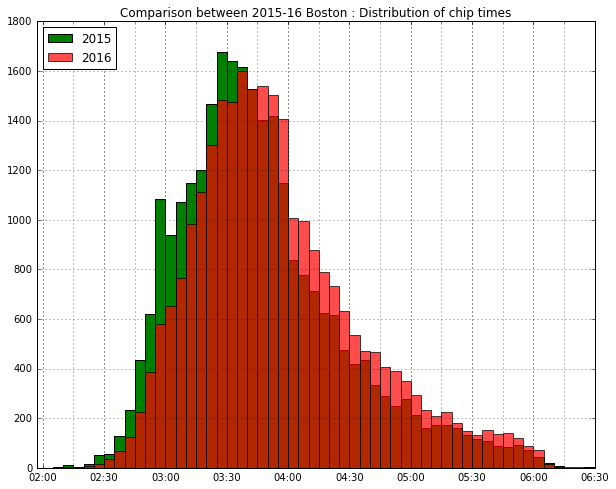

In [30]:
# comparing histograms of finish times for the 2 years

fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.hist(bos15off['epoch'], 
    bins=mdates.epoch2num(np.arange(60*60*1.5,60*60*8,60*5)), 
    color = ['green'], histtype='bar',align='mid',label=['2015'])
plt.hist(bos16off['epoch'], 
    bins=mdates.epoch2num(np.arange(60*60*1.5,60*60*8,60*5)), 
    color = ['red'], alpha = 0.7, histtype='bar',align='mid',label=['2016'])
ymax = max(ax.get_ylim())
xmax = 60*60*6.5

ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
xlocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.xaxis.set_minor_locator(xlocator)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
plt.xticks(rotation=0)
plt.grid(which='both',axis='both')
plt.legend(loc='upper left')
plt.title("Comparison between 2015-16 Boston : Distribution of chip times")
plt.xlim([mdates.epoch2num(60*60*1.95),mdates.epoch2num(xmax)])
plt.show()

### Finding "dual finishers" from 2015-6 Boston

Now that we've seen what the results look like and how they compare from one year to the next, let's identify the people who finished both years -- "dual finishers" -- and see how they handled the conditions.

We'll need to match names & ages from the official results and do some merges/joins.

Going through the process will take a few steps, which I outline here --
1. find those who "aged up" naturally (age increase of 1) between 2015-6
2. find those who stayed the same age for both races (because their birthdates were either APR 19 or 20)
3. find those who might have misreported their ages (age difference not 0 or 1)
4. find those whose first names were slightly different each year (and weren't found in step 1)
5. find those whose last names were slightly different each year

Each of these steps are a little involved, and the reader can choose to skip ahead and see the analysis after we've settled on our matches.

Long story short: we found that around 8450 runners finished in 2015 and returned to finish in 2016.

#### __*ageup*__

In [31]:
# first, let's take a look at how names appear in the official results
# we'll also list some of the other columns that will help us identify dual finishers
columns_i_want = ['bib','name','age','city','state']
bos15off[columns_i_want].sample(10)

,bib,name,age,city,state
3645,4584,"Moran, Kieran J",45,Pleasantville,NY
572,212,"Kariolis, Vasilis S",26,Boston,MA
2507,1599,"Basham, Cort",38,Bowling Green,KY
6128,8754,"Torreggiani, Roberto",41,Vimodrone,NaN
13730,16743,"Rutkiewicz, Jennifer M",35,Ann Arbor,MI
19650,22928,"Butler, Lisa B.",53,Granville Summit,PA
7848,11212,"Pulver, Eric J",50,Chippewa Falls,WI
19499,25135,"Folkert, Jacqueline",44,Redondo Beach,CA
24883,26504,"Fitzgerald, Paul D.",45,Northampton,MA
22565,27815,"Chagnon, Julie J.",45,Colorado Springs,CO


The names take on the following format: Last, First MI

Some people have middle initials, and others don't.

Some people's last names might be more than one word.

Some people's first names might be more than one word.

To work with __*name*__, we'll do the following --
1. normalize *name* (replace ñ with n, á with a, etc)
1. create __*fname*__ field: keep the first word after the comma
2. create __*lname*__ field: keep the entire last name, from the start of *name* to the comma
3. create __*name_mod*__ field: capitalize *fname* and *lname*, then combine with a space


In [32]:
# "normalize" name into name_mod
# (also normalize city into city_mod, for search purposes later on)
for df in [bos15off, bos16off]:
    df['name'] = df.apply(lambda row: unicodedata.normalize('NFD', row['name']).encode('ascii', 'ignore').replace(".",""),axis=1)
    # get rid of middle initial from first names
    df['fname'] = df.apply(lambda row: row['name'].split(",")[1].strip().split(" ")[0].strip(), axis=1)
    df['lname'] = df.apply(lambda row: row['name'].split(",")[0].strip(), axis=1)
    df['name_mod'] = df['fname'].str.upper() + " " + df['lname'].str.upper()
    df['city'].replace(np.nan,"",inplace=True)
    df['state'].replace(np.nan,"",inplace=True)
    df['city_mod'] = df['city'].str.upper() + ", " + df['state'].str.upper()

In [33]:
# add "age_up" to bos15off: the age for people on 4/18/2016, if their birthdays aren't 4/19-20
bos15off['age_up'] = bos15off['age'] + 1
ageup = pd.merge(bos15off, bos16off, left_on=['name_mod','age_up'], right_on=['name_mod','age'])
len(ageup)

8218

Note: Since we're merging two dataframes with a lot of the same column names, the merged dataframe (ageup) will have lots of columns with "_x" and "_y" suffixes.

We chose not to rename "_x" and "_y" as "_15" and "_16", and to leave "_x" and "_y" as is.

Keep this in mind for all merged dataframes that follow.

In [34]:
# find people from "ageup" who aren't the same person
# start with those whose city of residence changed between the 2 years
# (and a big time difference between the 2 years)
columns_i_want = ['name_mod','bib_x','bib_y','age_x','city_mod_x','city_mod_y','chip_x','chip_y','diff_t']

# calculate difference between finish times (in seconds; negative value means improved)
ageup['diff'] = ageup.chip_y.apply(get_sec) - ageup.chip_x.apply(get_sec)

ageup.assign(diff_t=lambda x: x['diff'].apply(get_time))[(ageup.city_mod_x!=ageup.city_mod_y) & (abs(ageup['diff'])>60*60*1)]\
    .sort_values(by='diff')[columns_i_want]

,name_mod,bib_x,bib_y,age_x,city_mod_x,city_mod_y,chip_x,chip_y,diff_t
8213,MOHAMMED ALKHUB,6769,9262,56,"REDFERN, NSW,","REDFERN, SYDNEY,",6:37:04,5:19:59,-1:17:05
7896,DELWYN WILLIAMSON,24077,24461,53,"JAMAICA PLAIN, MA","BOSTON, MA",4:58:29,3:50:56,-1:07:33
7297,SCOTT ROLFSON,3656,2362,36,"TORONTO, ON","CHICAGO, IL",4:20:14,3:13:28,-1:06:46
8189,RALPH BOYD,26764,26415,58,"CAMBRIDGE, MA","LAYTONSVILLE, MD",5:55:35,4:52:45,-1:02:50
6978,DAVID TANNASCOLI,1438,3295,32,"BROCKPORT, NY","WEBSTER, NY",4:09:47,3:08:19,-1:01:28
3016,SANDEEP BADVE,7571,12388,44,"CHICAGO, IL","FOSTER CITY, CA",3:21:51,4:22:08,1:00:17
5647,SHARLENE CHINN,21234,21824,58,"BURLINGAME, CA","IRVINE, CA",3:47:17,4:47:43,1:00:26
2748,JENNIFER SMITH,8765,20226,35,"SAN DIEGO, CA","LOS GATOS, CA",3:19:28,4:20:18,1:00:50
4499,JENNIFER RYAN,16455,29137,39,"FRISCO, TX","DORCHESTER, MA",3:35:00,4:36:32,1:01:32
6167,CASSIE GIBSON,19330,20050,37,"BONNEY LAKE, WA","SEATTLE, WA",3:53:03,4:54:48,1:01:45


In [35]:
# remove applicable rows from above
ageup = ageup[~(ageup.name_mod.isin(['STEPHEN LYNCH']) & (ageup.city_mod_x.isin(['ATHENS, PA'])) & (ageup.city_mod_y.isin(['GOODYEAR, AZ'])))]
ageup = ageup[~(ageup.name_mod.isin(['RYAN MCLAUGHLIN']) & (ageup.city_mod_x.isin(['CHICAGO, IL'])) & (ageup.city_mod_y.isin(['HEATHROW, FL'])))]
ageup = ageup[~(ageup.name_mod.isin(['JENNIFER RYAN']) & (ageup.bib_x.isin(['16455'])) & (ageup.bib_y.isin(['29137'])))]
ageup = ageup[~(ageup.name_mod.isin(['JENNIFER SMITH']) & (ageup.bib_x.isin(['8765'])) & (ageup.bib_y.isin(['20226'])))]
print(len(ageup))

8214


In [36]:
# find people from "ageup" who aren't the same person
# look for those whose bib # changed the most between the 2 years
columns_i_want = ['name_mod','bib_x','bib_y','age_x','city_mod_x','city_mod_y','chip_x','chip_y','bibdiff','diff_t']

ageup.assign(bib1=lambda x: x['bib_x'].str.replace("F","").apply(int), bib2=lambda x: x['bib_y'].str.replace("F","").apply(int))\
    .assign(bibdiff = lambda x: abs(x['bib2']-x['bib1']))\
    .assign(diff_t=lambda x: x['diff'].apply(get_time))[(ageup.city_mod_x!=ageup.city_mod_y)]\
    .sort_values(by='bibdiff',ascending=False)[columns_i_want][0:60]

,name_mod,bib_x,bib_y,age_x,city_mod_x,city_mod_y,chip_x,chip_y,bibdiff,diff_t
4207,STEPHEN BENSON,5525,31240,47,"EXCELSIOR, MN","WICHITA, KS",3:32:25,4:41:15,25715,1:08:50
3519,JEFFREY ARBEIT,2391,26716,32,"NEW YORK, NY","WASHINGTON, DC",3:26:27,3:37:52,24325,11:25
2116,CHARLES SCHERR,2991,26993,20,"CAMBRIDGE, MA","NEW YORK, NY",3:12:38,3:20:03,24002,7:25
1412,SAMUEL WILLIAMS,29583,5904,29,"BOSTON, MA","FRANKLIN, MA",3:04:19,3:30:33,23679,26:14
7494,ALICIA PINCINCE,8301,31962,35,"UXBRIDGE, MA","LAKEVILLE, MA",4:29:29,5:08:42,23661,39:13
4330,ROB TEREN,9672,31077,45,"UNIVERSITY HEIGHTS, OH","BEACHWOOD, OH",3:33:32,3:53:47,21405,20:15
1442,DAVID FAGNAN,27332,5988,27,"BOSTON, MA","SEATTLE, WA",3:04:36,3:53:19,21344,48:43
6112,MATTHEW WHITCOMB,26535,6957,43,"BOSTON, MA","PALOS VERDES, CA",3:52:20,4:35:45,19578,43:25
7141,ROBERT JOHNSON,27752,11985,50,"BRISTOL, RI","DEERFIELD, WI",4:15:07,3:42:20,15767,-32:47
5632,DEBRA LONGSTREET,23430,7700,46,"BOSTON, MA","CAMBRIDGE, MA",3:47:09,3:46:50,15730,-0:19


In [37]:
# remove applicable rows from above
ageup = ageup[~(ageup.name_mod.isin(['STEPHEN BENSON']) & (ageup.city_mod_x.isin(['EXCELSIOR, MN'])) & (ageup.city_mod_y.isin(['WICHITA, KS'])))]
ageup = ageup[~(ageup.name_mod.isin(['ROBERT JOHNSON']) & (ageup.city_mod_x.isin(['BRISTOL, RI'])) & (ageup.city_mod_y.isin(['DEERFIELD, WI'])))]
ageup = ageup[~(ageup.name_mod.isin(['TODD NELSON']) & (ageup.bib_x.isin(['3671'])) & (ageup.bib_y.isin(['9796'])))]
print(len(ageup))

8211


In [38]:
# find people from "ageup" who aren't the same person
# look for people with exact same name & age
columns_i_want = ['name_mod','bib_x','bib_y','age_x','city_mod_x','city_mod_y','chip_x','chip_y']
ageup[ageup[['name_mod','age_x']].duplicated(keep=False)][columns_i_want]

,name_mod,bib_x,bib_y,age_x,city_mod_x,city_mod_y,chip_x,chip_y
570,DAVID JOHNSON,4337,563,32,"BRANDON, FL","PLAINFIELD, IL",2:54:17,2:56:50
571,DAVID JOHNSON,4337,1639,32,"BRANDON, FL","BRANDON, FL",2:54:17,3:07:50
1142,MATTHEW ANDERSON,5797,4720,35,"EAST LYME, CT","EAST LYME, CT",3:00:43,3:07:23
1143,MATTHEW ANDERSON,5797,4065,35,"EAST LYME, CT","BURNSVILLE, MN",3:00:43,3:11:30
3074,SYLVAIN ROY,13013,12690,52,"STE-THERESE, QC","STE-THERESE, QC",3:22:23,3:42:20
3075,SYLVAIN ROY,13013,12607,52,"STE-THERESE, QC","CLARKSVILLE, MD",3:22:23,3:57:14
3897,JAMES FLAHERTY,13090,11067,56,"MT BALDY, CA","MT BALDY, CA",3:29:30,3:46:02
3898,JAMES FLAHERTY,16364,11067,56,"WESTERVILLE, OH","MT BALDY, CA",3:31:22,3:46:02
4019,STEPHANIE CLARK,16200,17252,34,"PHILADELPHIA, PA","LUTHERVILLE, MD",3:30:38,3:47:17
4020,STEPHANIE CLARK,16200,16551,34,"PHILADELPHIA, PA","YIGO, GU",3:30:38,4:04:35


In [39]:
# remove applicable rows from above
ageup = ageup[~(ageup.name_mod.isin(['DAVID JOHNSON']) & (ageup.city_mod_x.isin(['BRANDON, FL'])) & (ageup.city_mod_y.isin(['PLAINFIELD, IL'])))]
ageup = ageup[~(ageup.name_mod.isin(['MATTHEW ANDERSON']) & (ageup.city_mod_x.isin(['EAST LYME, CT'])) & (ageup.city_mod_y.isin(['BURNSVILLE, MN'])))]
ageup = ageup[~(ageup.name_mod.isin(['SYLVAIN ROY']) & (ageup.city_mod_x.isin(['STE-THERESE, QC'])) & (ageup.city_mod_y.isin(['CLARKSVILLE, MD'])))]
ageup = ageup[~(ageup.name_mod.isin(['JAMES FLAHERTY']) & (ageup.city_mod_x.isin(['WESTERVILLE, OH'])) & (ageup.city_mod_y.isin(['MT BALDY, CA'])))]
ageup = ageup[~(ageup.name_mod.isin(['STEPHANIE CLARK']) & (ageup.city_mod_x.isin(['PHILADELPHIA, PA'])) & (ageup.city_mod_y.isin(['YIGO, GU'])))]
ageup = ageup[~(ageup.name_mod.isin(['STEPHEN BENSON']) & (ageup.city_mod_x.isin(['EXCELSIOR, MN'])) & (ageup.city_mod_y.isin(['WICHITA, KS'])))]
ageup = ageup[~(ageup.name_mod.isin(['JENNIFER RYAN']) & (ageup.city_mod_x.isin(['FRISCO, TX'])) & (ageup.city_mod_y.isin(['DORCHESTER, MA'])))]
ageup = ageup[~(ageup.name_mod.isin(['JULIE COLLINS']) & (ageup.city_mod_x.isin(['WESTERVILLE, OH'])) & (ageup.city_mod_y.isin(['ATLANTA, GA'])))]
ageup = ageup[~(ageup.name_mod.isin(['JENNIFER BALDWIN']) & (ageup.city_mod_x.isin(['GLEN ALLEN, VA'])) & (ageup.city_mod_y.isin(['ST PAUL, MN'])))]
ageup = ageup[~(ageup.name_mod.isin(['PAUL JOSEPH']) & (ageup.city_mod_x.isin(['NORWELL, MA'])) & (ageup.city_mod_y.isin(['NATICK, MA'])))]
print(len(ageup))

8203


That's the bulk of the dual finishers: those who aged up 1 year and registered using the same name both years.

#### __*agesame*__

We also have to check those who were the same age for both races, as 2015's race was held on APR 20 and 2016's race came on APR 18.

Those with a birthday on APR 20 or APR 19 would be the same age on both 4/20/2015 and 4/18/2016, so let's merge the two dataframes on name_mod and age --

In [40]:
agesame = pd.merge(bos15off, bos16off, left_on=['name_mod','age'], right_on=['name_mod','age'])
len(agesame)

73

In [41]:
# find rows from "agesame" that contain info for 2 different people
# start with those whose city of residence changed between the 2 years
# (and a big chip time difference between the 2 years)
columns_i_want = ['name_mod','bib_x','bib_y','age','city_mod_x','city_mod_y','chip_x','chip_y','diff_t']

# calculate difference between finish times (in seconds; negative value indicates improvement)
agesame['diff'] = agesame.chip_y.apply(get_sec) - agesame.chip_x.apply(get_sec)

agesame.assign(diff_t=lambda x: x['diff'].apply(get_time))[(agesame.city_mod_x!=agesame.city_mod_y) & (abs(agesame['diff'])>60*60*0.35)]\
    .sort_values(by='diff')[columns_i_want]

,name_mod,bib_x,bib_y,age,city_mod_x,city_mod_y,chip_x,chip_y,diff_t
72,MICHAEL NELSON,31579,5831,47,"DORCHESTER, MA","GRAND RAPIDS, MI",5:59:32,3:13:09,-2:46:23
60,NATHAN SMITH,8382,3966,43,"SPRINGVILLE, UT","CORVALLIS, OR",4:03:34,3:00:03,-1:03:31
67,DAVID MOORE,22048,9466,60,"DAHLONEGA, GA","MOORPARK, CA",4:43:09,3:40:24,-1:02:45
71,KEVIN WHITE,29077,26869,37,"BOLTON, MA","SOUTH BOSTON, MA",5:45:37,4:51:12,-54:25
61,JENNIFER SMITH,22937,15333,46,"PETOSKEY, MI","NOVI, MI",4:05:00,3:18:27,-46:33
56,MARK ANDERSON,11057,12682,46,"LAYTON, UT","CLACKAMAS, OR",3:54:41,3:24:13,-30:28
32,DAVID SIMPSON,14019,13481,51,"LIVONIA, NY","LOUISVILLE, KY",3:28:59,3:57:43,28:44
17,DANIEL BROOKS,13318,9769,50,"ORCHARD PARK, NY","HAMBURG, NY",3:15:02,3:45:51,30:49
14,HE HUANG,4897,31264,33,"BRONX, NY","BEIJING,",3:08:39,3:58:43,50:04
37,JENNIFER GREEN,14579,31010,45,"BERKELEY, CA","HOPKINTON, MA",3:32:07,4:47:06,1:14:59


In [42]:
# remove applicable rows from above
agesame = agesame[~(agesame.name_mod.isin(['MICHAEL NELSON']) & (agesame.city_mod_x.isin(['DORCHESTER, MA'])) & (agesame.city_mod_y.isin(['GRAND RAPIDS, MI'])))]
agesame = agesame[~(agesame.name_mod.isin(['NATHAN SMITH']) & (agesame.city_mod_x.isin(['SPRINGVILLE, UT'])) & (agesame.city_mod_y.isin(['CORVALLIS, OR'])))]
agesame = agesame[~(agesame.name_mod.isin(['DAVID MOORE']) & (agesame.city_mod_x.isin(['DAHLONEGA, GA'])) & (agesame.city_mod_y.isin(['MOORPARK, CA'])))]
agesame = agesame[~(agesame.name_mod.isin(['HE HUANG']) & (agesame.city_mod_x.isin(['BRONX, NY'])) & (agesame.city_mod_y.isin(['BEIJING, '])))]
agesame = agesame[~(agesame.name_mod.isin(['JENNIFER GREEN']) & (agesame.city_mod_x.isin(['BERKELEY, CA'])) & (agesame.city_mod_y.isin(['HOPKINTON, MA'])))]
agesame = agesame[~(agesame.name_mod.isin(['TRACY JOHNSON']) & (agesame.city_mod_x.isin(['PROVIDENCE, RI'])) & (agesame.city_mod_y.isin(['OWINGS MILLS, MD'])))]
agesame = agesame[~(agesame.name_mod.isin(['JASON BUTLER']) & (agesame.city_mod_x.isin(['OKLAHOMA CITY, OK'])) & (agesame.city_mod_y.isin(['LONDON, '])))]
agesame = agesame[~(agesame.name_mod.isin(["PAUL O'CONNELL"]) & (agesame.city_mod_x.isin(['DUBLIN, '])) & (agesame.city_mod_y.isin(['MARSHFIELD, MA'])))]
agesame = agesame[~(agesame.name_mod.isin(["MICHAEL BURNS"]) & (agesame.city_mod_x.isin(['CAMP HILL, PA'])) & (agesame.city_mod_y.isin(['FARMINGVILLE, NY'])))]
agesame = agesame[~(agesame.name_mod.isin(["BRIAN WALSH"]) & (agesame.city_mod_x.isin(['MENDHAM, NJ'])) & (agesame.city_mod_y.isin(['FISHERS, IN'])))]
agesame = agesame[~(agesame.name_mod.isin(["NANCY SMITH"]) & (agesame.city_mod_x.isin(['NEW BRITAIN, PA'])) & (agesame.city_mod_y.isin(['KENNEBUNKPORT, ME'])))]
print(len(agesame))

62


In [43]:
# find people from "agesame" who aren't the same person
# look for those whose bib # changed the most between the 2 years
columns_i_want = ['name_mod','bib_x','bib_y','age','city_mod_x','city_mod_y','chip_x','chip_y','bibdiff','diff_t']

agesame.assign(bib1=lambda x: x['bib_x'].str.replace("F","").apply(int), bib2=lambda x: x['bib_y'].str.replace("F","").apply(int))\
    .assign(bibdiff = lambda x: abs(x['bib2']-x['bib1']))\
    .assign(diff_t=lambda x: x['diff'].apply(get_time))[(agesame.city_mod_x!=agesame.city_mod_y)]\
    .sort_values(by='bibdiff',ascending=False)[columns_i_want][0:60]

,name_mod,bib_x,bib_y,age,city_mod_x,city_mod_y,chip_x,chip_y,bibdiff,diff_t
23,TODD LYTLE,12467,2494,46,"DENVER, CO","CLERMONT, FL",3:23:42,3:22:50,9973,-0:52
11,JASON LEE,8548,758,40,"TULSA, OK","SAN FRANCISCO, CA",3:04:36,3:02:47,7790,-1:49
61,JENNIFER SMITH,22937,15333,46,"PETOSKEY, MI","NOVI, MI",4:05:00,3:18:27,7604,-46:33
26,THOMAS STONE,12497,5968,50,"GREENWOOD VILLAGE, CO","GREENWOOD, IN",3:25:19,3:25:47,6529,0:28
70,CHRISTOPHER DUNN,31311,26995,30,"DORCHESTER, MA","BOSTON, MA",5:12:38,4:51:43,4316,-20:55
17,DANIEL BROOKS,13318,9769,50,"ORCHARD PARK, NY","HAMBURG, NY",3:15:02,3:45:51,3549,30:49
59,ERIN LYNCH,31389,28240,39,"MILTON, MA","BOSTON, MA",3:58:48,5:17:16,3149,1:18:28
42,JAMES COOPER,17508,14559,55,"KNOXVILLE, TN","PARIS, KY",3:36:03,3:45:20,2949,9:17
20,JOHN WARNER,8507,5631,40,"OIL CITY, PA","WALTHAM, MA",3:20:38,3:06:38,2876,-14:00
71,KEVIN WHITE,29077,26869,37,"BOLTON, MA","SOUTH BOSTON, MA",5:45:37,4:51:12,2208,-54:25


In [44]:
# remove 1 row from above
agesame = agesame[~(agesame.name_mod.isin(['JASON LEE']) & (agesame.city_mod_x.isin(['TULSA, OK'])) & (agesame.city_mod_y.isin(['SAN FRANCISCO, CA'])))]
print(len(agesame))

61


In [45]:
# find people from "agesame" who aren't the same person
# look for people with exact same name & age
columns_i_want = ['name_mod','bib_x','bib_y','age','city_mod_x','city_mod_y','chip_x','chip_y']
agesame[agesame[['name_mod','age']].duplicated(keep=False)][columns_i_want]

,name_mod,bib_x,bib_y,age,city_mod_x,city_mod_y,chip_x,chip_y
61,JENNIFER SMITH,22937,15333,46,"PETOSKEY, MI","NOVI, MI",4:05:00,3:18:27
62,JENNIFER SMITH,22937,23427,46,"PETOSKEY, MI","WAUKEE, IA",4:05:00,4:07:05


In [46]:
# remove 2 rows of Jennifer Smiths (age 46)
agesame = agesame[~(agesame.name_mod.isin(['JENNIFER SMITH']) & (agesame.city_mod_x.isin(['PETOSKEY, MI'])) & (agesame.city_mod_y.isin(['NOVI, MI'])))]
agesame = agesame[~(agesame.name_mod.isin(['JENNIFER SMITH']) & (agesame.city_mod_x.isin(['PETOSKEY, MI'])) & (agesame.city_mod_y.isin(['WAUKEE, IA'])))]

print(len(agesame))

59


#### __*agediff*__

We've found runners who aged up and others who were the same age.

We should also consider the possibility that some people registered with wrong ages. (People sometimes misspell their name or city when they register for races, so it's worth trying to find people who get their age wrong.)

Let's merge the two data frames on name_mod, and then filter the results by removing the "natural age-ing" entries.

In [47]:
ageall = pd.merge(bos15off, bos16off, left_on=['name_mod'], right_on=['name_mod'])
len(ageall)

9003

In [48]:
# find people from same city with age difference other than 0 or 1 between 2015-16 Boston
columns_i_want = ['name_x','name_y','bib_x','bib_y','age_x','age_y','city_mod_x','city_mod_y','chip_x','chip_y']
ageall[(ageall.age_x!=(ageall.age_y-1)) & (ageall.age_x!=ageall.age_y) & (ageall.city_mod_x==ageall.city_mod_y)][columns_i_want]

,name_x,name_y,bib_x,bib_y,age_x,age_y,city_mod_x,city_mod_y,chip_x,chip_y
490,"Tadesse, Fasil","Tadesse, Fasil",7181,1722,43,47,"SAN DIEGO, CA","SAN DIEGO, CA",2:51:52,2:51:29
971,"Morris, Mike Jr","Morris, Mike",6009,25078,37,65,"TERRE HAUTE, IN","TERRE HAUTE, IN",2:57:50,3:45:11
2783,"Chan, Wai Fong","Chan, Wai Yee",8029,19247,43,42,"HONG KONG,","HONG KONG,",3:38:21,3:45:28
3950,"McKinnon, Lauchie M","McKinnon, Lauchie M",7544,8168,56,60,"SYDNEY, NS","SYDNEY, NS",3:26:19,3:21:55
6164,"Ward, Terrie","Ward, Terrie",19832,22492,45,53,"MARIETTA, GA","MARIETTA, GA",3:46:01,3:46:52
6924,"Lau, Wai Lam","Lau, Wai Kay",21769,18624,64,55,"HONG KONG,","HONG KONG,",3:54:13,5:39:54
7539,"Bradley, Larry","Bradley, Larry",18500,22851,57,60,"WINCHESTER, MA","WINCHESTER, MA",4:05:22,4:06:52
7735,"McDonnell, John J III","McDonnell, John J",29160,29131,25,54,"BOSTON, MA","BOSTON, MA",4:10:24,4:45:05
7737,"McDonnell, John J Jr","McDonnell, John J III",29159,29132,53,26,"BOSTON, MA","BOSTON, MA",4:44:44,4:00:42
7919,"Lee, Sung Re","Lee, Sung Jin",12026,9775,56,48,"SEOUL,","SEOUL,",4:16:12,4:16:16


Going by name and using the cities as a sanity check, it appears that there do seem to be a few cases of wrong age reporting. (One can also check race photos from both __[2015](https://www.marathonfoto.com/Landing/12902015S1/boston-marathon-2015)__ and __[2016](https://www.marathonfoto.com/Landing/12902016S1/boston-marathon-2016)__ to verify these cases.) Let's add them below --

In [49]:
# add the obvious cases from above into "agediff"
columns_i_want = ['name_x','name_y','bib_x','bib_y','age_x','age_y','city_mod_x','city_mod_y','chip_x','chip_y']

# create "agediff" by adding 1 entry from "ageall"
agediff = ageall[ageall.bib_x.isin(['7181']) & ageall.bib_y.isin(['1722'])] # Fasil Tadesse
agediff = pd.concat([agediff, ageall[ageall.bib_x.isin(['7544']) & ageall.bib_y.isin(['8168'])]]) # Lauchie McKinnon
agediff = pd.concat([agediff, ageall[ageall.bib_x.isin(['19832']) & ageall.bib_y.isin(['22492'])]]) # Terrie Ward
agediff = pd.concat([agediff, ageall[ageall.bib_x.isin(['18500']) & ageall.bib_y.isin(['22851'])]]) # Larry Bradley
agediff = pd.concat([agediff, ageall[ageall.bib_x.isin(['28244']) & ageall.bib_y.isin(['29080'])]]) # Denny Moran
agediff[columns_i_want]

,name_x,name_y,bib_x,bib_y,age_x,age_y,city_mod_x,city_mod_y,chip_x,chip_y
490,"Tadesse, Fasil","Tadesse, Fasil",7181,1722,43,47,"SAN DIEGO, CA","SAN DIEGO, CA",2:51:52,2:51:29
3950,"McKinnon, Lauchie M","McKinnon, Lauchie M",7544,8168,56,60,"SYDNEY, NS","SYDNEY, NS",3:26:19,3:21:55
6164,"Ward, Terrie","Ward, Terrie",19832,22492,45,53,"MARIETTA, GA","MARIETTA, GA",3:46:01,3:46:52
7539,"Bradley, Larry","Bradley, Larry",18500,22851,57,60,"WINCHESTER, MA","WINCHESTER, MA",4:05:22,4:06:52
8575,"Moran, Denny","Moran, Denny",28244,29080,42,44,"YONKERS, NY","YONKERS, NY",4:50:25,4:43:23


With the above, we looked at city to find people. Let's remove the restriction, and search by "bib difference" instead, meaning that we arrange the rows from *ageall* by the difference between the bib numbers in both years.

This might be a good way to find those who changed residences, or those who might have had similar bib numbers in both years (by virtue of not getting much faster or slower).

In [50]:
# find people from "agediff" by looking for those with smallest bib # differences between the 2 years
columns_i_want = ['name_x','name_y','bib_x','bib_y','age_x','age_y','city_mod_x','city_mod_y','chip_x','chip_y','bibdiff']

ageall.assign(bib1=lambda x: x['bib_x'].str.replace("F","").apply(int), bib2=lambda x: x['bib_y'].str.replace("F","").apply(int))\
    .assign(bibdiff = lambda x: abs(x['bib2']-x['bib1']))\
    [(ageall.age_x!=(ageall.age_y-1)) & (ageall.age_x!=ageall.age_y)]\
    .sort_values(by='bibdiff')[columns_i_want][0:30]

,name_x,name_y,bib_x,bib_y,age_x,age_y,city_mod_x,city_mod_y,chip_x,chip_y,bibdiff
5,"Boudalia, Said Sr","Boudalia, Said Sr",83,75,46,48,"VAS(BELLUNO),","BELLUNO,",2:24:49,2:27:41,8
7499,"Pelletier, Mark E","Pelletier, Mark W",27517,27527,40,54,"ASHLAND, MA","NORWELL, MA",4:33:36,5:04:44,10
8516,"Sullivan, Kevin M","Sullivan, Kevin M",28917,28932,31,38,"BOSTON, MA","BROOKLINE, MA",4:47:52,4:48:30,15
7737,"McDonnell, John J Jr","McDonnell, John J III",29159,29132,53,26,"BOSTON, MA","BOSTON, MA",4:44:44,4:00:42,27
7735,"McDonnell, John J III","McDonnell, John J",29160,29131,25,54,"BOSTON, MA","BOSTON, MA",4:10:24,4:45:05,29
564,"Davis, Michael","Davis, Michael J",1246,1276,33,25,"SCOTCH PLAINS, NJ","ATLANTA, GA",2:53:06,3:24:32,30
138,"Murphy, Timothy P","Murphy, Timothy A",1073,1108,32,44,"MORRISTOWN, NJ","RONKONKOMA, NY",2:42:12,3:04:20,35
1063,"Davis, John","Davis, John K",639,601,30,38,"FORNEY, TX","VIERA, FL",2:58:41,2:53:54,38
5031,"Jensen, Lars M","Jensen, Lars L",14199,14125,50,61,"NORRESUNDBY,","ROSKILDE,",3:34:57,3:46:53,74
6838,"Black, Jennifer H","Black, Jennifer E",25258,25333,63,55,"LOVELAND, OH","GLASTONBURY, CT",4:43:22,4:28:50,75


In [51]:
# add the obvious cases from above into "agediff"
# only 1 case (Said Boudalia), with 1 other possible case (Patrick Foley, age 34 in 2015, age 33 in 2016)
agediff = pd.concat([agediff, ageall[ageall.bib_x.isin(['83']) & ageall.bib_y.isin(['75'])]]) # Said Boudalia
#agediff = pd.concat([agediff, ageall[ageall.bib_x.isin(['29395']) & ageall.bib_y.isin(['29653'])]]) # Patrick Foley
print(len(agediff))

6


There weren't many cases of people entering with wrong ages.

But this raises the question: how does the Boston Athletic Association (BAA) verify the personal info of its entrants?

It seems that the BAA doesn't check, and instead relies on the "honor system".

It's a well-known problem that people cheat to get into the Boston Marathon:
- by cutting the course at a qualifying race
- by having a "bib mule" run a qualifying time for them

Lying about one's age can do the trick, too. For example, if I run 3:05:01 as a 32-year-old, I would miss my BQ requirement of 3:05 by 1 second, whereas if I ran the same 3:05:01 as a 35-year-old, I would beat my BQ requirement of 3:10 by 4:59.

In [52]:
# resetting indexes before dropping duplicates
ageup.reset_index(drop=True,inplace=True)
agesame.reset_index(drop=True,inplace=True)
agediff.reset_index(drop=True,inplace=True)
ageup = ageup.iloc[ageup[['bib_x','bib_y']].drop_duplicates().index]
agesame = agesame.iloc[agesame[['bib_x','bib_y']].drop_duplicates().index]
agediff = agediff.iloc[agediff[['bib_x','bib_y']].drop_duplicates().index]
print("{} {} {}".format(len(ageup), len(agesame), len(agediff)))

8203 59 6


#### Different first names

So far, we've assumed that people registered for both races using the same name.

But there are people whose name changed between the 2 years --
1. women who get married and change their surname
2. men who get married and change their surname
3. people who change their name for whatever reason
4. people who misspell their name

Another reason: the same person can register with alternative spellings. Common names like Christopher, Daniel, and Samuel can and often are shortened to Chris, Dan, and Sam.

Let's try to find these cases by merging the official results on last name and filtering by similar cities, states, and the first three letters of the first names.

In [53]:
# let's find those we might have missed due to differences in first names
fnamediff = pd.merge(bos15off, bos16off, left_on=['lname'], right_on=['lname'])
print(len(fnamediff))

addmore = fnamediff[ ( (fnamediff.city_mod_x==fnamediff.city_mod_y) | (fnamediff.state_x==fnamediff.state_y) )
    & (fnamediff.sex_x==fnamediff.sex_y) 
    & (fnamediff.fname_x!=fnamediff.fname_y) 
    & ( (fnamediff.age_x==fnamediff.age_y) | (fnamediff.age_y-fnamediff.age_x==1) )
    & ( (fnamediff.apply(lambda row: row['fname_y'].upper().startswith(row['fname_x'][0:3].upper()),axis=1)==1) | (fnamediff.apply(lambda row: row['fname_x'].upper().startswith(row['fname_y'][0:3].upper()),axis=1)==1) )]
print(len(addmore))

198291
130


In [54]:
# taking a look at these new candidates
columns_i_want = ['fname_x','fname_y','lname','bib_x','bib_y','age_x','age_y','city_mod_x','city_mod_y','chip_x','chip_y']
addmore.sort_values(by='lname')[columns_i_want][0:30]

,fname_x,fname_y,lname,bib_x,bib_y,age_x,age_y,city_mod_x,city_mod_y,chip_x,chip_y
89494,Dan,Daniel,Adams,8569,6662,42,43,"FLEMING ISLAND, FL","FLEMING ISLAND, FL",3:40:43,3:18:40
92526,Kenneth,Ken,Anderson,25149,25725,72,73,"KITCHENER, ON","KITCHENER, ON",4:21:33,4:51:01
62229,Matthew,Matt,Andrews,27387,30050,42,43,"WATERLOO, ON","WATERLOO, ON",4:08:08,4:23:59
193802,Betty,Bettysue,Annala,18842,19904,48,49,"ROSSLYN, ON","ROSSLYN, ON",3:39:59,3:47:25
145072,Robert,Rob,Arend,1807,1450,21,22,"WINSTON-SALEM, NC","WINSTON SALEM, NC",2:54:19,2:50:00
188146,Catherine,Catey,Ball,20160,19512,36,37,"SALT LAKE CITY, UT","HERRIMAN, UT",4:19:53,3:46:06
159475,R,Robert,Barron,17922,18543,57,58,"NEWBURGH, IN","NEWBURGH, IN",3:34:46,3:51:34
61242,Nick,Nicholas,Bedbury,355,429,26,27,"EAST SYRACUSE, NY","EAST SYRACUSE, NY",2:39:26,2:39:28
197453,Cassandra,Cassi,Belmarsh,25686,27049,43,44,"SCITUATE, MA","SCITUATE, MA",4:29:31,4:40:22
198200,Matthew,Matt,Bergin,26524,26910,54,55,"MILTON, MA","MILTON, MA",5:33:56,5:32:26


We can see that it's easy to miss finding matches due to different name spellings --
-  Many people alternate with nicknames (Nicholas/Nick, Bettysue/Betty, Toniann/Toni).
-  Some people go by initials (R Barron, E Crawford).
-  Some people use hyphens (Huan-Chou).
-  Some people misspell their name (Shaaanon).

So, we've added them into *addmore*.

Next, we want to find more people we might have missed (i.e., not found by "addmore").  

The algorithm above looked for similarities in first names within the first three characters; that is, it'll find matches between Nicholas/Nick, Philip/Phil, Christopher/Chris, Daniel/Dan, Kenneth/Ken, etc.  

However, there are more difficult name pairs: Cindy/Cynthia, Mike/Michael, Bill/William, Joe/Joseph, Robert/Bob, etc.  

We'll add those names into a list and find entries from "fnamediff" that meet most of the previous criteria, with the new caveat that the two first names have to both be in the "trouble_names" list.

In [55]:
# problem name pairs: Cindy/Cynthia, Mike/Michael, Bill/William, Charles/Chuck, Joe/Joseph, 
# Maria/Malena, Missy/Melissa, Karoline/Katie, Jay/Jerome, Jack/John, etc
columns_i_want = ['fname_x','fname_y','lname','bib_x','bib_y','age_x','age_y','city_mod_x','city_mod_y','chip_x','chip_y']
trouble_names = ['Joe','Joseph','Mike','Mikey','Michael','Cindy','Cynthia','Missy','Melissa',
    'Jay','Jerome','Bill','William','Will','Charles','Chuck','Jack','John','Jon', 'Gerald','Jerry', 
    'Catherine','Katie','Kathryn','Katy', 'Ted','Theodore','Ed','Edward', 'Robert','Bob', 'Anthony','Tony','Antonio',
    'Amanda','Amy', 'Thomas','Tom', 'James','Jim', 'Abigail','Abby', 'Rebecca','Becky','Becca',
    'Suzanne','Susan','Suzie','Sue','Susanne', 'Michele','Michelle','Shelly', 'Richard','Dick',
    'Abraham','Abe', 'Agnes','Aggie', 'Nicole','Nikki', 'Elizabeth','Beth','Liz',
    'Henry','Hank', 'Larry','Lawrence']
trouble_names_df = (fnamediff[ ( (fnamediff.city_mod_x==fnamediff.city_mod_y) | (fnamediff.state_x==fnamediff.state_y) )
    & (fnamediff.sex_x==fnamediff.sex_y) 
    & (fnamediff.fname_x!=fnamediff.fname_y) 
    & ( (fnamediff.age_y-fnamediff.age_x==1) )
    & (~fnamediff.index.isin(addmore.index))
    & (fnamediff.fname_x.isin(trouble_names) & fnamediff.fname_y.isin(trouble_names))])
(trouble_names_df[columns_i_want])

,fname_x,fname_y,lname,bib_x,bib_y,age_x,age_y,city_mod_x,city_mod_y,chip_x,chip_y
49437,Joe,Joseph,Smith,27583,30156,50,51,"NEEDHAM, MA","NEEDHAM, MA",3:47:04,3:57:47
61243,Thomas,Tom,Finneran,647,431,23,24,"SCITUATE, MA","BOSTON, MA",2:39:27,3:57:23
69446,Shelly,Michelle,Fisher,18520,18863,40,41,"CARMEL, IN","CARMEL, IN",3:46:46,4:08:05
87451,Lawrence,Larry,Aller,520,1997,36,37,"NEWTON, MA","WEST NEWTON, MA",2:44:07,3:09:23
96872,Missy,Melissa,Peters,18748,21628,40,41,"ROCKLIN, CA","ROCKLIN, CA",3:44:47,3:52:55
132692,James,Jim,Driscoll,1090,1843,24,25,"AMBLER, PA","AMBLER, PA",2:52:35,3:05:11
141850,Joe,Joseph,Byra,906,1045,45,46,"ATTLEBORO, MA","ATTLEBORO, MA",2:53:15,3:17:46
150106,Bill,William,Harrison,18216,25711,70,71,"NEW BEDFORD, MA","NEW BEDFORD, MA",4:09:40,4:22:43
151427,Joseph,Joe,Furdek,5488,2922,38,39,"LOUISVILLE, KY","LOUISVILLE, KY",2:56:49,3:11:14
155920,Mike,Michael,Girouard,1878,3235,45,46,"READING, MA","READING, MA",2:57:38,3:07:32


As you can see, there are lots of pairs that involve Mike/Michael, Bill/William, Chuck/Charles, and Joe/Joseph.

Also turning up are Ed/Edward pairs, which resulted from Ed/Ted/Edward being in "trouble_names"; Ed/Edward pairs should already have been found by the "addmore" algorithm.

These redundant Ed/Edward entries will get dropped shortly, when we add "trouble_names_df" to "addmore" and then drop duplicates from "addmore".

In [56]:
print(len(trouble_names_df))
# take out John & William Gray of Boston
trouble_names_df = trouble_names_df[~(trouble_names_df.bib_x.isin(['28798']) & trouble_names_df.bib_y.isin(['30631']))]
# take out James & Michael Cushing
trouble_names_df = trouble_names_df[~(trouble_names_df.bib_x.isin(['31316']) & trouble_names_df.bib_y.isin(['30016']))]
print(len(trouble_names_df))
addmore = pd.concat([addmore, trouble_names_df])
print(len(addmore))
addmore.reset_index(drop=True,inplace=True)
addmore = addmore.iloc[addmore[['bib_x','bib_y']].drop_duplicates().index]
addmore.reset_index(drop=True,inplace=True)
print(len(addmore))

33
31
161
161


#### Different last names

Similarly, people might have variations in their last names.

Here are some of the reasons --
1. apostrophes
2. hyphens
3. multiple words

Note that we're not explicitly trying to find those whose last names changed due to marriage.

Let's merge the official results on first name and continue to filter on similar conditions as above.

In [57]:
# let's try to find people whose last name changed
lnamediff = pd.merge(bos15off, bos16off, left_on=['fname'], right_on=['fname'])
print(len(lnamediff))

lname_df = lnamediff[ ( (lnamediff.city_mod_x==lnamediff.city_mod_y) | (lnamediff.state_x==lnamediff.state_y) )
    & (lnamediff.sex_x==lnamediff.sex_y) 
    #& (lnamediff.sex_x=='F')
    & (lnamediff.lname_x!=lnamediff.lname_y) 
    & ( (lnamediff.age_x==lnamediff.age_y) | (lnamediff.age_y-lnamediff.age_x==1) ) ]
print(len(lname_df))

2175576
9866


In [58]:
# taking a look at these new candidates (last name mismatches due to ' or - or space)
columns_i_want = ['fname','lname_x','lname_y','bib_x','bib_y','age_x','age_y','city_mod_x','city_mod_y','chip_x','chip_y']
num_letters = 5
lnamediff_add = (lname_df[ ( (lname_df.city_mod_x==lname_df.city_mod_y) | (lname_df.state_x==lname_df.state_y) )
   & (lname_df.name_mod_x!=lname_df.name_mod_y) 
   & (lname_df.age_x!=lname_df.age_y) 
   & ( (lname_df.apply(lambda row: (row['lname_x'].replace("'","")[0:num_letters].upper()) in row['lname_y'].replace("'","").upper(),axis=1)==1) 
      | (lname_df.apply(lambda row: (row['lname_y'].replace("'","")[0:num_letters].upper()) in row['lname_x'].replace("'","").upper(),axis=1)==1) )
    ].sort_values(by='fname'))
lnamediff_add[columns_i_want]

,fname,lname_x,lname_y,bib_x,bib_y,age_x,age_y,city_mod_x,city_mod_y,chip_x,chip_y
2105939,Abby,Knight,Knight Einspahr,13738,8926,31,32,"OMAHA, NE","OMAHA, NE",3:12:34,3:28:04
2004542,Abraham,Cohen-Bucay,Cohen,30145,27523,32,33,"BOSTON, MA","BOSTON, MA",4:00:52,3:47:12
1177925,Adam,Bright,Bright Md,10773,11166,49,50,"SARASOTA, FL","SARASOTA, FL",3:25:05,3:36:23
1647702,Alison,Bartlett- O'Donald,Bartlett-O'Donald,29666,29774,42,43,"SOUTH HADLEY, MA","SOUTH HADLEY, MA",4:06:46,4:53:41
1934420,Amy,Snyder,Tay-Snyder,24580,25199,56,57,"LANSDALE, PA","LANDSALE, PA",4:09:32,3:59:00
1941627,Amy,Costandi-Gomes,Costandi,25860,27719,28,29,"MANVILLE, RI","MANVILLE, RI",5:16:46,5:52:31
2089486,Cynthia,Mendez-Karr,Mendez Karr,12100,11590,43,44,"MCALLEN, TX","MCALLEN, TX",3:20:07,3:52:29
2085699,Donna,Lajoie Paurowski,Paurowski,26550,31169,55,56,"BOSTON, MA","BOSTON, MA",4:59:16,5:06:27
2175344,Dora,Tavel-Sanchez Luz,Tavel-Sanchez,26856,27813,41,42,"FRAMINGHAM, MA","FRAMINGHAM, MA",4:29:07,4:24:39
2162957,Eileen,O'Connor,Oconnor,21048,19367,44,45,"WEST ROXBURY, MA","WEST ROXBURY, MA",3:42:36,3:45:23


In [59]:
# remove applicable rows from above
print(len(lnamediff_add))
# take out Juan Martinez & Juan Carvajal Martin
lnamediff_add = lnamediff_add[~(lnamediff_add.bib_x.isin(['4063']) & lnamediff_add.bib_y.isin(['4691']))]
# take out Michael Conn & Michael O'Connor
lnamediff_add = lnamediff_add[~(lnamediff_add.bib_x.isin(['5887']) & lnamediff_add.bib_y.isin(['8554']))]
print(len(lnamediff_add))
# 30

32
30


In [60]:
# taking a look at female candidates (maiden to married name)
columns_i_want = ['fname','lname_x','lname_y','bib_x','bib_y','age_x','age_y','city_mod_x','city_mod_y','chip_x','chip_y']
lname_df[(lname_df.sex_x=='F') 
         & (lname_df.city_mod_x==lname_df.city_mod_y) 
         & (lname_df.name_mod_x!=lname_df.name_mod_y) 
         & (lname_df.age_x!=lname_df.age_y) 
         & (~lname_df.lname_x.str.contains("['-]") 
         & ~lname_df.lname_y.str.contains("'| "))].sort_values(by='fname')[columns_i_want]
# there are lots of candidates from Boston, as expected
# one possible match is Christine Irish & Christine Hein, who were bib F113 & F111
# But we'll refrain from adding anyone here; we were treating this just as an exercise

,fname,lname_x,lname_y,bib_x,bib_y,age_x,age_y,city_mod_x,city_mod_y,chip_x,chip_y
2125503,Alexandra,Hempel,Leo,11631,14657,27,28,"DENVER, CO","DENVER, CO",3:14:10,3:26:01
1987467,Allison,Postlethwait,Crouse,28623,30506,25,26,"BOSTON, MA","BOSTON, MA",5:40:06,4:19:59
1983770,Allison,Goldstein,Malecki,10664,8666,29,30,"JERSEY CITY, NJ","JERSEY CITY, NJ",2:58:14,3:10:14
1986156,Allison,Keller,Crouse,26736,30506,25,26,"BOSTON, MA","BOSTON, MA",3:47:26,4:19:59
1797722,Amanda,Maggs,Goodwin,15331,29761,30,31,"BOSTON, MA","BOSTON, MA",3:23:52,4:37:58
1803707,Amanda,Heglin,Goodwin,29506,29761,30,31,"BOSTON, MA","BOSTON, MA",4:47:02,4:37:58
1804466,Amanda,Holm,Potter,29815,6991,31,32,"BOSTON, MA","BOSTON, MA",5:28:47,3:12:57
1804548,Amanda,Holm,Plaisted,29815,26483,31,32,"BOSTON, MA","BOSTON, MA",5:28:47,4:42:54
1796253,Amanda,Potter,Plaisted,7306,26483,31,32,"BOSTON, MA","BOSTON, MA",3:06:12,4:42:54
1921781,Amy,Trutor,Lussier,30631,26476,29,30,"BOSTON, MA","BOSTON, MA",3:37:37,5:22:31


At this point we'll stop adding names.

There might be some that are left out, but we've made some effort to find the vast majority of dual finishers, and what we have is a group of decent size.

We'll concatenate 5 dataframes into "compare" --

In [61]:
compare = pd.concat([ageup, agesame, agediff, addmore, lnamediff_add])
print(len(compare))
compare.reset_index(drop=True,inplace=True)
# dropping extra entries: RG Witchey, AmyBeth Bourgault, BJ Christenson (introduced by addmore)
compare = compare.iloc[compare[['bib_x','bib_y']].drop_duplicates().index]
compare.reset_index(drop=True,inplace=True)
compare.fillna("",inplace=True)
compare['bibdiff'] = compare.bib_y.str.replace("F","").apply(int) - compare.bib_x.str.replace("F","").apply(int)
compare['diff'] = compare.chip_y.apply(get_sec) - compare.chip_x.apply(get_sec)
# agesame won't have columns age_x & age_y
compare['age_x'] = compare.apply(lambda row: int(row.age) if row.age_x=="" else int(row.age_x),axis=1)
compare['age_y'] = compare.apply(lambda row: int(row.age) if row.age_y=="" else int(row.age_y),axis=1)
# lnamediff_add won't have column name_mod
compare['name_mod_x'] = compare.apply(lambda row: row.name_mod if row.name_mod_x==""
                                      else row.name_mod_x,axis=1)
compare['name_mod_y'] = compare.apply(lambda row: row.name_mod if row.name_mod_y==""
                                      else row.name_mod_y,axis=1)
compare['name_mod'] = compare.apply(lambda row: row.name_mod_x if row.name_mod==""
                                      else row.name_mod,axis=1)
print(len(compare))
#8456

8459
8456


In [62]:
# find duplicate bib_x-s & bib_y-s (last pass at cleaning "compare" before analysis)
columns_i_want = ['name_x','name_y','bib_x','bib_y','age_x','age_y','city_mod_x','city_mod_y','chip_x','chip_y']
compare[compare.bib_x.duplicated(keep=False) | compare.bib_y.duplicated(keep=False)].sort_values(by=['name_x'])[columns_i_want]

,name_x,name_y,bib_x,bib_y,age_x,age_y,city_mod_x,city_mod_y,chip_x,chip_y
3993,"Cooper, James","Cooper, James",11692,14559,54,55,"PARIS, KY","PARIS, KY",3:30:26,3:45:20
4607,"Cooper, James A","Cooper, James A",17508,19691,55,56,"KNOXVILLE, TN","KNOXVILLE, TN",3:36:03,3:52:59
8237,"Cooper, James A","Cooper, James",17508,14559,55,55,"KNOXVILLE, TN","PARIS, KY",3:36:03,3:45:20
7997,"Dunn, Christopher M","Dunn, Christopher M",31311,28549,30,31,"DORCHESTER, MA","DORCHESTER, MA",5:12:38,5:07:40
8260,"Dunn, Christopher M","Dunn, Christopher P",31311,26995,30,30,"DORCHESTER, MA","BOSTON, MA",5:12:38,4:51:43
2992,"Gervais, Charles","Gervais, Charles",10167,12324,47,48,"DIEPPE, NB","DIEPPE, NB",3:21:44,3:31:31
8219,"Gervais, Charles","Gervais, Charles K",10167,9650,47,47,"DIEPPE, NB","ST. CATHARINES, ON",3:21:44,3:39:59
2290,"Gervais, Charles K","Gervais, Charles K",9797,9650,46,47,"ST. CATHARINES, ON","ST. CATHARINES, ON",3:14:43,3:39:59
8244,"Jones, Sarah G","Jones, Sarah M",22075,20301,45,45,"CHICAGO, IL","GROSSE POINTE FARMS, MI",3:42:11,3:45:27
5204,"Jones, Sarah G","Jones, Sarah",22075,21651,45,46,"CHICAGO, IL","CHICAGO, IL",3:42:11,3:37:06


In [63]:
# remove as appropriate
print(len(compare))
compare = compare[~(compare.bib_x.isin(['17508']) & compare.bib_y.isin(['14559']))] # James Cooper
compare = compare[~(compare.bib_x.isin(['31311']) & compare.bib_y.isin(['26995']))] # Christopher Dunn
compare = compare[~(compare.bib_x.isin(['10167']) & compare.bib_y.isin(['9650']))] # Charles Gervais
compare = compare[~(compare.bib_x.isin(['22075']) & compare.bib_y.isin(['20301']))] # Sarah Jones
compare = compare[~(compare.bib_x.isin(['2228']) & compare.bib_y.isin(['1348']))] # John Kelly
compare = compare[~(compare.bib_x.isin(['28273']) & compare.bib_y.isin(['25186']))] # Mar. O'Donnell
compare = compare[~(compare.bib_x.isin(['24687']) & compare.bib_y.isin(['30659']))] # Mar. O'Donnell
compare = compare[~(compare.bib_x.isin(['12467']) & compare.bib_y.isin(['2494']))] # Todd Lytle
compare = compare[~(compare.bib_x.isin(['14019']) & compare.bib_y.isin(['13481']))] # David Simpson
compare = compare[~(compare.bib_x.isin(['1898']) & compare.bib_y.isin(['3692']))] # Scott Snyder
compare = compare[~(compare.bib_x.isin(['12497']) & compare.bib_y.isin(['5968']))] # Thomas Stone
compare.reset_index(drop=True,inplace=True)
print(len(compare))
#8445

8456
8445


In [64]:
# let's see the percentage split between men/women
print(compare.sex_y.value_counts(normalize=True))
print(bos15off.sex.value_counts(normalize=True))
print(bos16off.sex.value_counts(normalize=True))

M    0.575252
F    0.424748
Name: sex_y, dtype: float64
M    0.548199
F    0.451801
Name: sex, dtype: float64
M    0.543109
F    0.456891
Name: sex, dtype: float64


Of the dual finishers, 57.5% were men, compared to 54.5% overall for both years.

This suggests that we might not have found enough women above, by name or age. It's certainly the case that women are more likely than men to change their last name when they get married, so it's likely that we missed a few of these cases.

In [65]:
print("{:.3%} were the same age both years".format(len(compare[compare.age_x==compare.age_y])*1.0/len(compare)))
print("{:.3%} is the expected value for runners having birthdays on APR 19 or 20 (assuming uniformity)".format(2*1.0/365))

0.628% were the same age both years
0.548% is the expected value for runners having birthdays on APR 19 or 20 (assuming uniformity)


We have a slightly higher-than-expected percentage of dual finishers who were the same age for both races.

This might mean that:
1. some of those with the same age might have entered a wrong birthday for one of the races, or
2. we haven't found all of the possible dual finishers (for reasons that include the one slightly above: married names)

Assuming uniformity, the law of large numbers indicates that 2/365 (0.548%) of the population has birthdates of APR 19 or 20, but this "law" might not hold in practice, since some dates, like APR 1 (and APR 20, to a lesser degree), have bias against them.

In any case, we acknowledge that limitations exist in our method of finding dual finishers, and that it's very likely we missed a few.

But we'll proceed with what we have, as there are still lots of insights to uncover with the 8400+ dual finishers that we have.

In [66]:
# let's see how the dual finishers fared
print("{:5} ran slower in 2015".format(len(compare[compare.chip_x>compare.chip_y])))
print("{:5} ran slower in 2016".format(len(compare[compare.chip_x<compare.chip_y])))
print("{:5} ran the same time".format(len(compare[compare.chip_x==compare.chip_y])))

 2014 ran slower in 2015
 6425 ran slower in 2016
    6 ran the same time


In [67]:
# in percentages:
print("{:7.3%} ran slower in 2015".format(len(compare[compare.chip_x>compare.chip_y])*1.0/len(compare)))
print("{:7.3%} ran slower in 2016".format(len(compare[compare.chip_x<compare.chip_y])*1.0/len(compare)))
print("{:7.3%} ran the same time".format(len(compare[compare.chip_x==compare.chip_y])*1.0/len(compare)))

23.848% ran slower in 2015
76.081% ran slower in 2016
 0.071% ran the same time


Over three-quarters of the dual finishers ran slower in 2016, the hot year.

It shouldn't have come as a surprise that the majority of dual finishers were slower in 2016, since we've seen the race statistics from both years. Still, 76% is quite staggering.

Let's try to visualize the degree of regression/improvement --

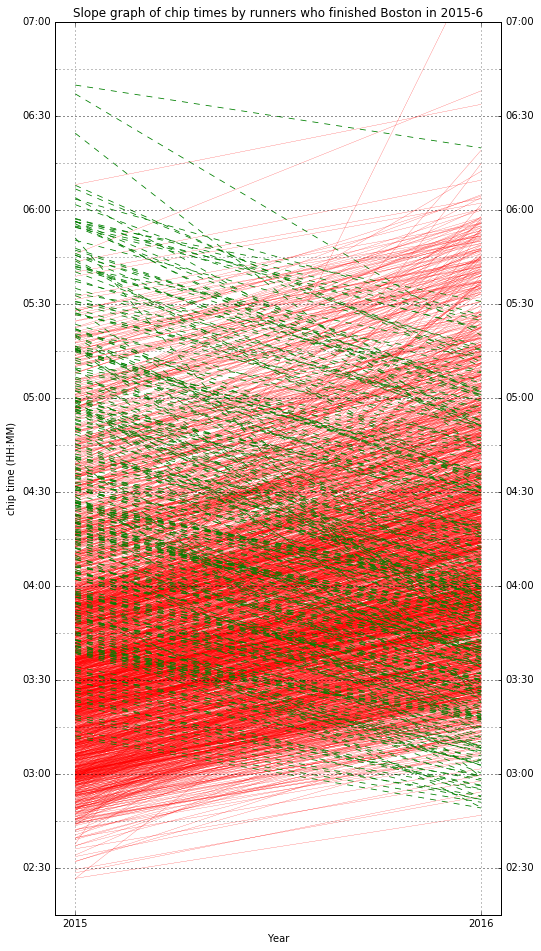

In [68]:
# slope graph
# plot only those who improved/regressed by X minutes between 2015-6
margin = 60*20 # seconds
fig, ax = plt.subplots(1,1, figsize=(8,16))
for x in compare.index[0:]:
    # improvements in green
    if compare.iloc[x]['seconds_x'] > compare.iloc[x]['seconds_y'] + margin:
        ax.plot([-1, 1], compare.iloc[x][['epoch_x','epoch_y']], 'g--', aa=True, linewidth=0.8)
    # regressions in red
    if compare.iloc[x]['seconds_x'] < compare.iloc[x]['seconds_y'] - margin:
        ax.plot([-1, 1], compare.iloc[x][['epoch_x','epoch_y']], 'r-', aa=True, linewidth=0.2)

ax.yaxis.set_major_locator(mdates.HourLocator())
ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ylocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.yaxis.set_minor_locator(ylocator)
ax.yaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
ax.tick_params(labeltop=False, labelright=True)
plt.xticks(rotation=0)
plt.grid(which='both',axis='both')
plt.ylabel("chip time (HH:MM)")
plt.title("Slope graph of chip times by runners who finished Boston in 2015-6")
plt.xlim([-1.1, 1.1])
plt.xticks([-1, 1], ['2015', '2016'])
plt.ylim([mdates.epoch2num(60*60*2.25), mdates.epoch2num(60*60*7)])
plt.xlabel("Year")
plt.show()

With this "slope graph", we're trying to get a sense of the magnitude of differences.

Here, we've resorted to filtering out everyone whose time differences were less than 20 minutes. (The plot would otherwise be overly cluttered with 6400+ red lines.)

It might still be hard to tell, but there are way more red lines than dotted green lines.

Let's see the histogram of chip times for dual finishers, relative to the overall results for the two years --

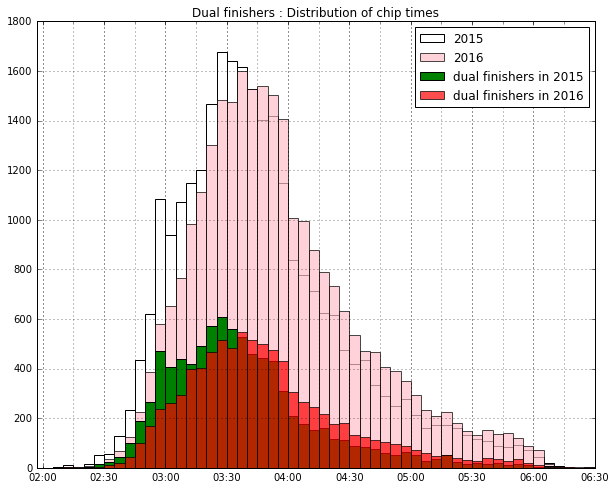

In [69]:
# plot histogram of finish times, with bin sizes of 5 minutes !!

fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.hist(bos15off['epoch'], 
    bins=mdates.epoch2num(np.arange(60*60*1.5,60*60*8,60*5)), 
    color = ['white'], histtype='bar',align='mid',label=['2015'])
plt.hist(bos16off['epoch'], 
    bins=mdates.epoch2num(np.arange(60*60*1.5,60*60*8,60*5)), 
    color = ['pink'], alpha = 0.7, histtype='bar',align='mid',label=['2016'])
plt.hist(compare['epoch_x'], 
    bins=mdates.epoch2num(np.arange(60*60*1.5,60*60*8,60*5)), 
    color = ['green'], histtype='bar',align='mid',label=['dual finishers in 2015'])
plt.hist(compare['epoch_y'], 
    bins=mdates.epoch2num(np.arange(60*60*1.5,60*60*8,60*5)), 
    color = ['red'], alpha = 0.7, histtype='bar',align='mid',label=['dual finishers in 2016'])
ymax = max(ax.get_ylim())
xmax = 60*60*6.5

ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
xlocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.xaxis.set_minor_locator(xlocator)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
plt.xticks(rotation=0)
plt.grid(which='both',axis='both')
plt.legend(loc='upper right')
plt.title("Dual finishers : Distribution of chip times")
plt.xlim([mdates.epoch2num(60*60*1.95),mdates.epoch2num(xmax)])
plt.show()

Again, no major surprises in that the 2016 plots are shifted to the right.

Let's see a time vs time graph for the dual finishers --

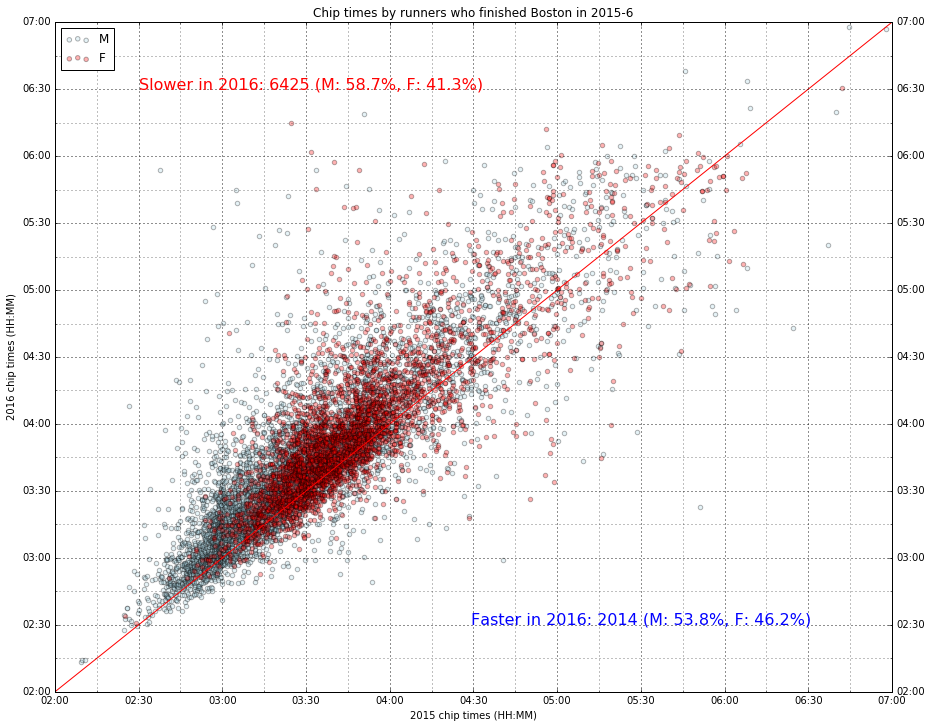

In [70]:
# time, on both x-axis & y-axis
fig, ax = plt.subplots(1,1, figsize=(15,12))

ax.scatter(compare.query("sex_x=='M'")['epoch_x'], compare.query("sex_x=='M'")['epoch_y'], alpha=0.3, c='lightblue', label="M")
ax.scatter(compare.query("sex_x=='F'")['epoch_x'], compare.query("sex_x=='F'")['epoch_y'], alpha=0.3, c='r', label="F")
ax.plot([mdates.epoch2num(60*60*1), mdates.epoch2num(60*60*8)],[mdates.epoch2num(60*60*1), mdates.epoch2num(60*60*8)], 'r-')

ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.yaxis.set_major_locator(mdates.HourLocator())
ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
xlocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ylocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.xaxis.set_minor_locator(xlocator)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
ax.yaxis.set_minor_locator(ylocator)
ax.yaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
ax.tick_params(labeltop=False, labelright=True)
plt.xticks(rotation=0)
slower_in_15 = len(compare[(compare.seconds_x>compare.seconds_y)])
slower_in_15_m = len(compare[(compare.seconds_x>compare.seconds_y) & (compare.sex_x=='M')])*1.0/slower_in_15
slower_in_15_f = len(compare[(compare.seconds_x>compare.seconds_y) & (compare.sex_x=='F')])*1.0/slower_in_15
slower_in_16 = len(compare[(compare.seconds_x<compare.seconds_y)])
slower_in_16_m = len(compare[(compare.seconds_x<compare.seconds_y) & (compare.sex_x=='M')])*1.0/slower_in_16
slower_in_16_f = len(compare[(compare.seconds_x<compare.seconds_y) & (compare.sex_x=='F')])*1.0/slower_in_16

plt.text(mdates.epoch2num(60*60*2.5), mdates.epoch2num(60*60*6.5), "Slower in 2016: {} (M: {:.1%}, F: {:.1%})".format(slower_in_16, slower_in_16_m, slower_in_16_f), color='r',size=16, horizontalalignment='left')
plt.text(mdates.epoch2num(60*60*5.5), mdates.epoch2num(60*60*2.5), "Faster in 2016: {} (M: {:.1%}, F: {:.1%})".format(slower_in_15, slower_in_15_m, slower_in_15_f), color='b',size=16, horizontalalignment='center')

plt.grid(which='both',axis='both')
plt.legend(loc='upper left')
plt.title("Chip times by runners who finished Boston in 2015-6")
plt.xlim([mdates.epoch2num(60*60*2), mdates.epoch2num(60*60*7)])
plt.ylim([mdates.epoch2num(60*60*2), mdates.epoch2num(60*60*7)])
plt.xlabel("2015 chip times (HH:MM)")
plt.ylabel("2016 chip times (HH:MM)")
#fig.colorbar(im, ax=ax)
plt.show()

Here, we're plotting "time vs time": 2015 on the x-axis, and 2016 on the y-axis.

The red line represents y=x, or equal performance both years. We don't have to guess what proportion of the dots lie above the line, since we already showed above that 76% of the dual finishers fared worse in 2016.

The red dots represent women, and they were plotted on top of the blue dots, so a lot of the blue dots might be obscured by red dots. It might be hard to guestimate the proportions of men and women on both sides of the red line (through visual inspection), so we've printed the percentages on the plot itself.

But it's not just about which side of the line that the dots fall, since we also get to see the magnitude of the differences. The amount of vertical displacement from the line ("residual error", if you will) represents the amount of regression/improvement. Going by visual inspection, it appears that, in regression cases, the extreme cases were mostly men.

It's reasonable to think that there might be a mistake with the most extreme cases. Were they really the same person? It's possible that we matched people incorrectly, meaning that we have rows in *compare* of people with the same name & age who weren't the same person. Let's examine *compare* for the most extreme cases, with the top 30 improvements and top 30 regressions --

In [71]:
# let's take a look at the extreme cases of improvement/regression
columns_i_want = ['name_x','name_y','bib_x','bib_y','age_x','age_y','city_mod_x','city_mod_y','chip_x','chip_y']
compare.sort_values(by='diff')[columns_i_want]

,name_x,name_y,bib_x,bib_y,age_x,age_y,city_mod_x,city_mod_y,chip_x,chip_y
8161,"Tebbenkamp, Joel","Tebbenkamp, Joel D",2172,2519,36,37,"SAINT LOUIS, MO","SAINT LOUIS, MO",5:51:04,3:23:01
7666,"Rietsma, Lee A II","Rietsma, Lee",2073,4451,37,38,"LAND O LAKES, FL","LAND O LAKES, FL",4:40:29,2:59:00
8197,"Cason, William T","Cason, William T",23327,23256,60,61,"CHESAPEAKE, VA","CHESAPEAKE, VA",6:24:30,4:43:07
8096,"Lepp, Harry","Lepp, Harry",24785,15561,58,59,"DANIELSON, CT","DANIELSON, CT",5:28:44,3:56:33
8023,"Clark, Bette","Clark, Bette",21010,21634,59,60,"YONKERS, NY","YONKERS, NY",5:15:50,3:44:48
8031,"Falck, Phillip","Falck, Phillip R",14114,14749,51,52,"GERMANTOWN, WI","GERMANTOWN, WI",5:16:36,3:46:26
7972,"Taylor, John W III","Taylor, John III",18566,29814,56,57,"DES MOINES, IA","DES MOINES, IA",5:09:24,3:43:34
7889,"MacPherson, Mary Jane","Macpherson, Mary Jane",16388,17665,35,36,"LATHAM, NY","LATHAM, NY",4:59:01,3:33:51
7794,"Knoop, Lindsay","Knoop, Lindsay",14011,17630,31,32,"ELKHORN, NE","ELKHORN, NE",4:50:25,3:26:15
8050,"Starck, Sara J","Starck, Sara",18442,13504,33,34,"ARLINGTON, VA","ARLINGTON, VA",5:19:28,3:59:44


Going by visual inspection and printing out name/bib/city details for the above, nothing jumps out as being a false match. Some of these people had high bib numbers, indicating that they were charity runners, and with charity runners it's hard to gauge their running ability.

It's also possible that runners ran to their abilities one year, and were injured the other year and couldn't run fast regardless of weather.

Qualifying for Boston is a major achievement, and for many people it's qualifying that matters, with the race being the cherry on top. It's a good reminder that not everybody tries for fast times at Boston, which has a net downhill but is a notoriously difficult course.

In [72]:
# how did dual finishers fare with BQs?
print("{:5} BQed both years".format(len(compare[(compare.BQ_x==1) & (compare.BQ_y==1)])))
print("{:5} BQed in 2015 but not in 2016".format(len(compare[(compare.BQ_x==1) & (compare.BQ_y==0)])))
print("{:5} BQed in 2016 but not in 2015".format(len(compare[(compare.BQ_x==0) & (compare.BQ_y==1)])))
print("{:5} didn't BQ in either year".format(len(compare[(compare.BQ_x==0) & (compare.BQ_y==0)])))
print("")
# percentages
print("{:7.2%} BQed both years".format(len(compare[(compare.BQ_x==1) & (compare.BQ_y==1)])*1.0/len(compare)))
print("{:7.2%} BQed in 2015 but not in 2016".format(len(compare[(compare.BQ_x==1) & (compare.BQ_y==0)])*1.0/len(compare)))
print("{:7.2%} BQed in 2016 but not in 2015".format(len(compare[(compare.BQ_x==0) & (compare.BQ_y==1)])*1.0/len(compare)))
print("{:7.2%} didn't BQ in either year".format(len(compare[(compare.BQ_x==0) & (compare.BQ_y==0)])*1.0/len(compare)))

 3674 BQed both years
 2236 BQed in 2015 but not in 2016
  330 BQed in 2016 but not in 2015
 2205 didn't BQ in either year

 43.51% BQed both years
 26.48% BQed in 2015 but not in 2016
  3.91% BQed in 2016 but not in 2015
 26.11% didn't BQ in either year


We can visualize these numbers in the following section!

(How good is a 43% BQ rate for both years? Interestingly, it's about halfway between the overall BQ% of 2015 Boston (50%), and the overall BQ% of 2016 Boston (36%).)

## Some like it hot (and don't like it cold)

Anecdotally, it seems that women prefer warmer temperatures than men, and that men don't need to dress as warmly for colder weather.

The results from 2015-6 Boston might give us a glimpse at how this theory plays out.

2015 Boston had cold weather: 40s & 50s (F), rainy at times, with some headwind.

2016 Boston had warm weather: 67+ (F), sunny.

The overall BQ numbers can be found above: nearly 50% in 2015, around 36% in 2016.

Breaking down by sex, men had a slightly higher BQ% than women in 2015, while women had a higher BQ% than men in 2016.

Let's plot "BQdiff" for both years, with 2015 on the x-axis and 2016 on the y-axis. Quadrant III (the lower left quadrant) would show those with negative BQdiff for both years, meaning that runners in that quadrant BQed both years, while Quadrant I (the upper right quadrant) would show those who didn't BQ in either year --

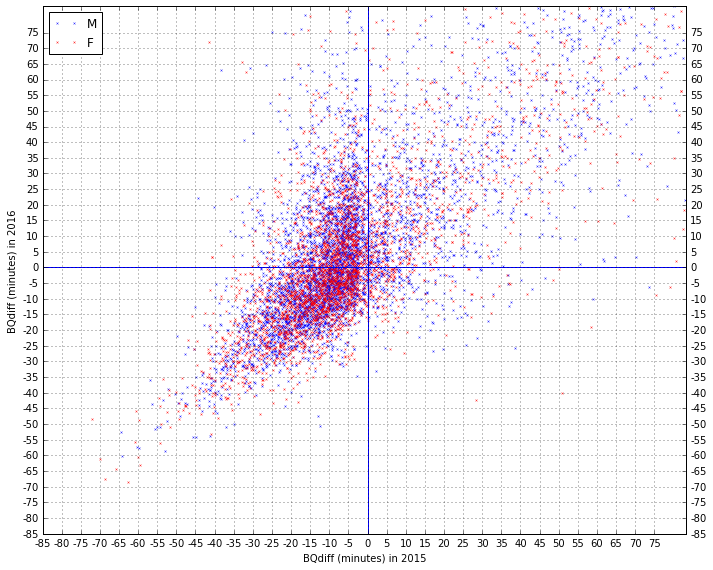

In [73]:
# BQdiff both years (4 quadrants)
plotthis = True
if plotthis == True:
    fig, ax = plt.subplots(1,1, figsize=(10,8))

    plotx = compare.query("sex_x=='M'")['BQdiff_x']
    ploty = compare.query("sex_x=='M'")['BQdiff_y']
    ax.plot(plotx,ploty, 'bx', aa=True, markersize=2, label='M', alpha=0.8)

    plotx = compare.query("sex_x=='F'")['BQdiff_x']
    ploty = compare.query("sex_x=='F'")['BQdiff_y']
    ax.plot(plotx,ploty, 'rx', aa=True, markersize=2, label='F', alpha=0.8)
    
    bq15_y_bq16_y = len(compare[(compare.BQ_x==1) & (compare.BQ_y==1)])
    bq15_y_bq16_n = len(compare[(compare.BQ_x==1) & (compare.BQ_y==0)])
    bq15_n_bq16_y = len(compare[(compare.BQ_x==0) & (compare.BQ_y==1)])
    bq15_n_bq16_n = len(compare[(compare.BQ_x==0) & (compare.BQ_y==0)])

    plt.xlabel("BQdiff (minutes) in 2015")
    plt.ylabel("BQdiff (minutes) in 2016")
    xlim_range = [-5000, 5000]
    ylim_range = xlim_range
    plt.xlim(xlim_range)
    plt.ylim(ylim_range)
    plt.xticks([x*60*5 for x in range(int(np.floor(min(xlim_range)/300.0)),int(np.ceil(max(xlim_range))/300.0))],[x*5 for x in range(int(np.floor(min(xlim_range)/300.0)),int(np.ceil(max(xlim_range))/300.0))])
    plt.yticks([x*60*5 for x in range(int(np.floor(min(ylim_range)/300.0)),int(np.ceil(max(ylim_range))/300.0))],[x*5 for x in range(int(np.floor(min(ylim_range)/300.0)),int(np.ceil(max(ylim_range))/300.0))])
    plt.axhline()
    plt.axvline()
    ax.tick_params(labeltop=False, labelright=True)
    plt.legend(loc='upper left')
    plt.grid(axis='both')
    plt.tight_layout()
    plt.show()

Less than half of the 8400+ dual finishers BQed in both years, but Quadrant III is still the most populated, with a decent mix of men & women.

We've limited the axes ranges so that we're not showing everybody in Quadrant I, which has many points north of 90 minutes slower than BQ. Quadrant I has high dispersion. The other quadrants have many more points clustered closer to the origin.

What gets interesting is what's happening in Quadrants II & IV. Visually inspecting them doesn't give a great idea of how many of the blue & red Xs there are, partly due to the limited axes ranges, but also because the red Xs are plotted after the blue Xs and might obscure the blue ones underneath (as in a previous plot of 2015-6 chip times).

So, let's add some numbers to the quadrants --

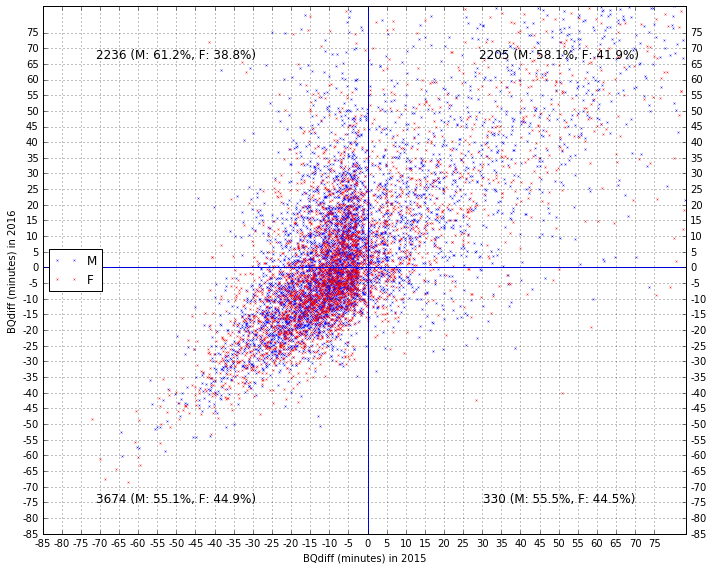

In [74]:
# BQdiff both years (4 quadrants)
plotthis = True
if plotthis == True:
    fig, ax = plt.subplots(1,1, figsize=(10,8))

    plotx = compare.query("sex_x=='M'")['BQdiff_x']
    ploty = compare.query("sex_x=='M'")['BQdiff_y']
    ax.plot(plotx,ploty, 'bx', aa=True, markersize=2, label='M', alpha=0.8)

    plotx = compare.query("sex_x=='F'")['BQdiff_x']
    ploty = compare.query("sex_x=='F'")['BQdiff_y']
    ax.plot(plotx,ploty, 'rx', aa=True, markersize=2, label='F', alpha=0.8)
    
    bq15_y_bq16_y_m = len(compare[(compare.BQ_x==1) & (compare.BQ_y==1) & (compare.sex_x=='M')])*1.0/bq15_y_bq16_y
    bq15_y_bq16_n_m = len(compare[(compare.BQ_x==1) & (compare.BQ_y==0) & (compare.sex_x=='M')])*1.0/bq15_y_bq16_n
    bq15_n_bq16_y_m = len(compare[(compare.BQ_x==0) & (compare.BQ_y==1) & (compare.sex_x=='M')])*1.0/bq15_n_bq16_y
    bq15_n_bq16_n_m = len(compare[(compare.BQ_x==0) & (compare.BQ_y==0) & (compare.sex_x=='M')])*1.0/bq15_n_bq16_n
    
    bq15_y_bq16_y_f = len(compare[(compare.BQ_x==1) & (compare.BQ_y==1) & (compare.sex_x=='F')])*1.0/bq15_y_bq16_y
    bq15_y_bq16_n_f = len(compare[(compare.BQ_x==1) & (compare.BQ_y==0) & (compare.sex_x=='F')])*1.0/bq15_y_bq16_n
    bq15_n_bq16_y_f = len(compare[(compare.BQ_x==0) & (compare.BQ_y==1) & (compare.sex_x=='F')])*1.0/bq15_n_bq16_y
    bq15_n_bq16_n_f = len(compare[(compare.BQ_x==0) & (compare.BQ_y==0) & (compare.sex_x=='F')])*1.0/bq15_n_bq16_n

    plt.text(-3000, -4500, "{} (M: {:.1%}, F: {:.1%})".format(bq15_y_bq16_y, bq15_y_bq16_y_m, bq15_y_bq16_y_f), size=12, horizontalalignment='center')
    plt.text(-3000, 4000, "{} (M: {:.1%}, F: {:.1%})".format(bq15_y_bq16_n, bq15_y_bq16_n_m, bq15_y_bq16_n_f), size=12, horizontalalignment='center')
    plt.text(3000, -4500, "{} (M: {:.1%}, F: {:.1%})".format(bq15_n_bq16_y, bq15_n_bq16_y_m, bq15_n_bq16_y_f), size=12, horizontalalignment='center')
    plt.text(3000, 4000, "{} (M: {:.1%}, F: {:.1%})".format(bq15_n_bq16_n, bq15_n_bq16_n_m, bq15_n_bq16_n_f), size=12, horizontalalignment='center')
    plt.xlabel("BQdiff (minutes) in 2015")
    plt.ylabel("BQdiff (minutes) in 2016")
    xlim_range = [-5000, 5000]
    ylim_range = xlim_range
    plt.xlim(xlim_range)
    plt.ylim(ylim_range)
    plt.xticks([x*60*5 for x in range(int(np.floor(min(xlim_range)/300.0)),int(np.ceil(max(xlim_range))/300.0))],[x*5 for x in range(int(np.floor(min(xlim_range)/300.0)),int(np.ceil(max(xlim_range))/300.0))])
    plt.yticks([x*60*5 for x in range(int(np.floor(min(ylim_range)/300.0)),int(np.ceil(max(ylim_range))/300.0))],[x*5 for x in range(int(np.floor(min(ylim_range)/300.0)),int(np.ceil(max(ylim_range))/300.0))])
    plt.axhline()
    plt.axvline()
    ax.tick_params(labeltop=False, labelright=True)
    plt.legend(loc='center left')
    plt.grid(axis='both')
    plt.tight_layout()
    plt.show()

There isn't a single quadrant that has more women than men, but keep in mind that the "magic number" is 57.5%: the percentage of the dual finishers that are men.

In other words, quadrants that are less than 57.5% men are actually underrepresented by men. We know that only 4% of dual finishers are in Quadrant IV. But it's overrepresented by women (as is Quadrant III).

Quadrant II, meanwhile, is way overrepresented by men. Remember, this is the quadrant that represents those who BQed in a cold year and didn't BQ in a hot year. It's not necessarily the case that women "love" hot running weather; it just seems that they're much better at running in hotter conditions than men.

##### Miscellaneous

In [75]:
# here are the people who had the same bib # both years
columns_i_want = ['name_x','name_y','bib_x','bib_y','age_x','age_y','city_mod_x','city_mod_y','chip_x','chip_y']
compare[compare.bib_x==compare.bib_y][columns_i_want]
# the guy with bib 1968, Amby Burfoot, was the winner of the Boston Marathon in 1968
# (past winners get free entry into the race for life, without needing to re-qualify each year)

,name_x,name_y,bib_x,bib_y,age_x,age_y,city_mod_x,city_mod_y,chip_x,chip_y
32,"Blas, Wayne L","Blas, Wayne",171,171,37,38,"HAVRE DE GRACE, MD","HAVRE DE GRACE, MD",2:33:13,2:37:23
92,"Dionne, Hilary K","Dionne, Hilary K",F21,F21,29,30,"CHARLESTOWN, MA","CHARLESTOWN, MA",2:40:42,2:50:56
379,"Wrenn, Bean K","Wrenn, Bean K",F105,F105,41,42,"BOULDER, CO","BOULDER, CO",2:50:32,3:03:17
1056,"Demchko, Caitrin","Demchko, Caitrin",4382,4382,25,26,"NANUET, NY","BABYLON, NY",2:59:53,3:00:28
3436,"Buss, Gary R","Buss, Gary R",14228,14228,51,52,"BLACKSBURG, VA","BLACKSBURG, VA",3:25:49,3:35:48
6617,"Rosenblum, Lee","Rosenblum, Lee",23582,23582,60,61,"JUPITER, FL","JUPITER, FL",4:00:30,3:58:20
7220,"Burfoot, Amby","Burfoot, Amby",1968,1968,68,69,"MYSTIC, CT","MYSTIC, CT",4:18:09,4:17:48
8259,"Mish, Brad","Mish, Bradley",982,982,27,28,"DORCHESTER, MA","DORCHESTER, MA",2:32:36,2:48:26


In [76]:
# here are the people who ran the exact same time both years
columns_i_want = ['name_x','name_y','bib_x','bib_y','age_x','age_y','city_mod_x','city_mod_y','chip_x','chip_y']
compare[compare.seconds_x==compare.seconds_y][columns_i_want]

,name_x,name_y,bib_x,bib_y,age_x,age_y,city_mod_x,city_mod_y,chip_x,chip_y
54,"Neill, Ian T","Neill, Ian",518,201,30,31,"BOSTON, MA","CAMBRIDGE, MA",2:37:26,2:37:26
3511,"Nieto, Veronica","Nieto, Veronica",13091,13600,41,42,"LOMA LINDA, CA","LOMA LINDA, CA",3:26:26,3:26:26
3853,"Hetzer, Nicole K","Hetzer, Nicole K",14707,16477,33,34,"SANTA MONICA, CA","SANTA MONICA, CA",3:29:13,3:29:13
4769,"Bagley, Sean M","Bagley, Sean",10026,10988,43,44,"LYNN, MA","LYNN, MA",3:37:29,3:37:29
4793,"Helsel, Theresa S","Helsel, Theresa",13347,16473,38,39,"ORLANDO, FL","ORLANDO, FL",3:37:45,3:37:45
8291,"Schmitt, Tom J Jr","Schmitt, Tommy J Jr",6759,6938,37,38,"MACEDONIA, OH","MACEDONIA, OH",3:07:28,3:07:28


In [77]:
compare['wave_corral_x'] = pd.merge(compare, bos15ent, left_on='bib_x', right_on='bib', how='left')['wave_corral']
compare['wave_corral_y'] = pd.merge(compare, bos16ent, left_on='bib_y', right_on='bib', how='left')['wave_corral']
print(len(compare[compare.wave_corral_x==compare.wave_corral_y]))

2486


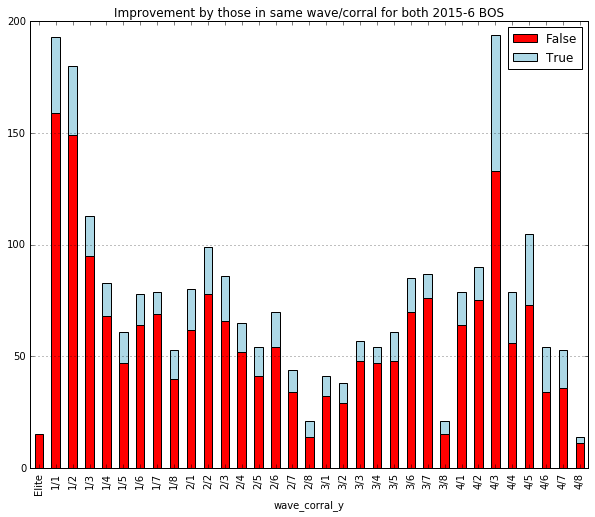

In [78]:
compare['improved'] = (compare['diff'] < 0)
# improvement by wave_corral

finishers = pd.pivot_table(compare[compare.wave_corral_x==compare.wave_corral_y], columns='improved', values='bib_y', index ='wave_corral_y', aggfunc=len)
finishers = finishers.reindex(['Elite'] + list(finishers.index[0:-1]))
finishers.plot(kind='bar', stacked=True, color=['red','lightblue'], figsize=(10,8))
plt.grid(which='both',axis='y')
plt.title("Improvement by those in same wave/corral for both 2015-6 BOS")
plt.legend(loc='upper right')
plt.show()

No surprise that none of the corrals had a majority of dual finishers improve.

It shouldn't be too surprising that none of the returning elites improved. (It's worth pointing out that, during the colder year, many of the top finishers avoided much of the wet weather by finishing before the rain began in earnest. (If the reader doesn't believe us, check the photographs of the male and female finishers.)) Elites have to run as fast as they "have to" in order to beat as many of their fellow racers as possible. It doesn't matter if the winning time is slower, because all that matters is placing.

It appears that corral 4/3 had the highest number of dual finishers, along with a decent percentage of people who ran faster in the hot year. In theory, it shouldn't be surprising if "back of the pack-ers" improved in higher numbers, since they have more "slack" to work with than those in Wave 1. The counterargument is that those in Wave 4 should be expected to do worse, since they're out there in adverse conditions for longer periods of time.

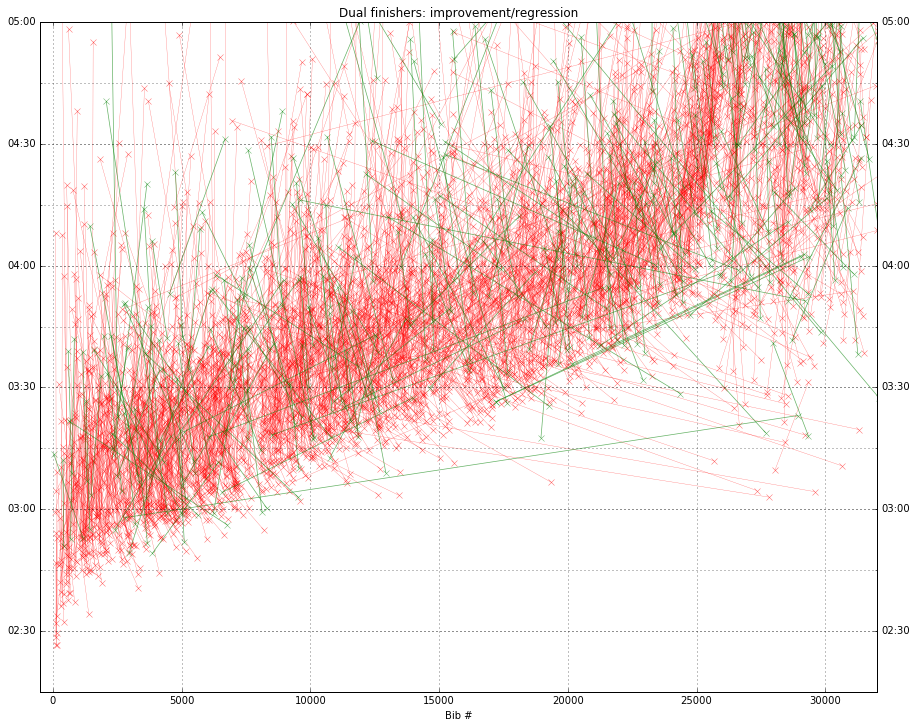

In [79]:
# "super" slope graph: combine the slope graph with the chip vs bib graph
# plot only those who improved/regressed by X minutes between 2015-6
fig, ax = plt.subplots(1,1, figsize=(15,12))
margin = 60*20 # seconds
for x in compare.index[0:]:
    # improvement
    if compare.loc[x]['seconds_x'] > compare.loc[x]['seconds_y'] + margin:
        plt.plot([int(compare.loc[x,'bib_x'].replace("F","")),int(compare.loc[x,'bib_y'].replace("F",""))],
            compare.loc[x][['epoch_x','epoch_y']], 'g-x', aa=True, linewidth=0.7, alpha=0.6)
    # regression
    elif compare.loc[x]['seconds_x'] < compare.loc[x]['seconds_y'] - margin:
        plt.plot([int(compare.loc[x,'bib_x'].replace("F","")),int(compare.loc[x,'bib_y'].replace("F",""))],
            compare.loc[x][['epoch_x','epoch_y']], 'r-x', aa=True, linewidth=0.3, alpha=0.6)

ax.yaxis.set_major_locator(mdates.HourLocator())
ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ylocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.yaxis.set_minor_locator(ylocator)
ax.yaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
plt.xticks(rotation=0)
ax.tick_params(labeltop=False, labelright=True)
plt.grid(which='both',axis='both')
#plt.legend(loc='lower right')
plt.title("Dual finishers: improvement/regression")
plt.xlim([-500, 32000])
plt.ylim([mdates.epoch2num(60*60*2.25), mdates.epoch2num(60*60*5)])
plt.xlabel("Bib #")
plt.show()

As with the earlier slope graph, here we're plotting only those who improved/regressed by 20+ minutes. (Otherwise the plot would be too cluttered.)

Green lines, unlike the earlier slope graph, can have either positive or negative slope in the traditional y=+-mx sense. The key thing to remember for this graph is that the green lines originate from the higher point, while the red lines start from the lower point.

This is a good way to see outliers, as before. Long lines in the x-direction, running from the higher bib numbers, indicate those who were charity runners one year and non-charity runners the other year.

In [80]:
# it's worth checking if large bib differences for the same name are actually 2 different people
# let's look at the largest abs(bibdiff) for those who weren't in Wave 4 during either year
columns_i_want = ['name_x','name_y','bib_x','bib_y','age_x','age_y','city_mod_x','city_mod_y','chip_x','chip_y']
compare.assign(bibdiffabs=compare.bibdiff.apply(abs))\
    [~compare.wave_corral_x.str.startswith("4") 
    & ~compare.wave_corral_y.str.startswith("4")]\
    .sort_values(by='bibdiffabs',ascending=False)[columns_i_want][0:60]
# nothing jumps out as being a mismatched name

,name_x,name_y,bib_x,bib_y,age_x,age_y,city_mod_x,city_mod_y,chip_x,chip_y
6761,"Pirrung, Roy","Pirrung, Roy",6993,22811,66,67,"KOHLER, WI","KOHLER, WI",4:04:00,4:21:35
5620,"Longstreet, Debra M","Longstreet, Debra M",23430,7700,46,47,"BOSTON, MA","CAMBRIDGE, MA",3:47:09,3:46:50
6264,"Levan, Emily","Levan, Emily",21363,6055,42,43,"RANDOLPH CENTER, VT","RANDOLPH CENTER, VT",3:54:35,3:17:48
851,"Bugbee, Patrick J","Bugbee, Patrick",17753,3435,31,32,"CAMBRIDGE, MA","CAMBRIDGE, MA",2:58:08,2:52:52
6485,"McDonald, Matthew F","McDonald, Matthew F",8915,22503,62,63,"VANCOUVER, WA","VANCOUVER, WA",3:57:51,3:55:43
1607,"Comment, Kristen","Comment, Kristen",19351,6616,40,41,"KANSAS CITY, MO","KANSAS CITY, MO",3:06:38,3:52:20
6059,"Oscal, Mario","Oscal, Mario",4738,17362,61,62,"BREA, CA","BREA, CA",3:51:58,4:34:33
5560,"Nixon, Sarah","Nixon, Sarah",10201,22571,50,51,"MEDFIELD, MA","MEDFIELD, MA",3:46:27,3:43:14
6928,"Barrett, Stephen W","Barrett, Stephen W",11141,23385,59,60,"CANTERBURY, NH","CANTERBURY, NH",4:08:45,4:05:08
3550,"Bartholic, Claire E","Bartholic, Claire",20031,8616,39,40,"ASHEVILLE, NC","ASHEVILLE, NC",3:26:44,3:11:26


In [81]:
columns_i_want = ['name_x','bib_x','bib_y','age_x','age_y','city_mod_x','city_mod_y','chip_x','chip_y','split5_time_x','split5_time_y']
# faster in first half, slower overall
print(len(compare[~(compare.splits_x.isnull() | compare.splits_y.isnull())
        & (compare.split5_time_y<compare.split5_time_x) & (compare.chip_x<compare.chip_y)][columns_i_want]))
# faster in first half, faster overall
print(len(compare[~(compare.splits_x.isnull() | compare.splits_y.isnull())
        & (compare.split5_time_y<compare.split5_time_x) & (compare.chip_y<compare.chip_x)][columns_i_want]))
# slower in first half, slower overall
print(len(compare[~(compare.splits_x.isnull() | compare.splits_y.isnull())
        & (compare.split5_time_x<compare.split5_time_y) & (compare.chip_x<compare.chip_y)][columns_i_want]))
# slower in first half, faster overall
print(len(compare[~(compare.splits_x.isnull() | compare.splits_y.isnull())
        & (compare.split5_time_x<compare.split5_time_y) & (compare.chip_y<compare.chip_x)][columns_i_want]))

1309
1555
5104
457


In [82]:
# find select people
columns_i_want = ['name_x','name_y','bib_x','bib_y','age_x','age_y','city_mod_x','city_mod_y','chip_x','chip_y','split5_time_x','split5_time_y','2ndhalf_x','2ndhalf_y','splits_x','splits_y','stdpace_x','stdpace_y']
compare[compare.name_mod.str.contains("DESISA")][columns_i_want]

,name_x,name_y,bib_x,bib_y,age_x,age_y,city_mod_x,city_mod_y,chip_x,chip_y,split5_time_x,split5_time_y,2ndhalf_x,2ndhalf_y,splits_x,splits_y,stdpace_x,stdpace_y
0,"Desisa, Lelisa","Desisa, Lelisa",3,1,25,26,"AMBO,","AMBO,",2:09:17,2:13:32,1:04:02,1:06:46,1:05:15,1:06:46,73,0,10.112807,10.778285


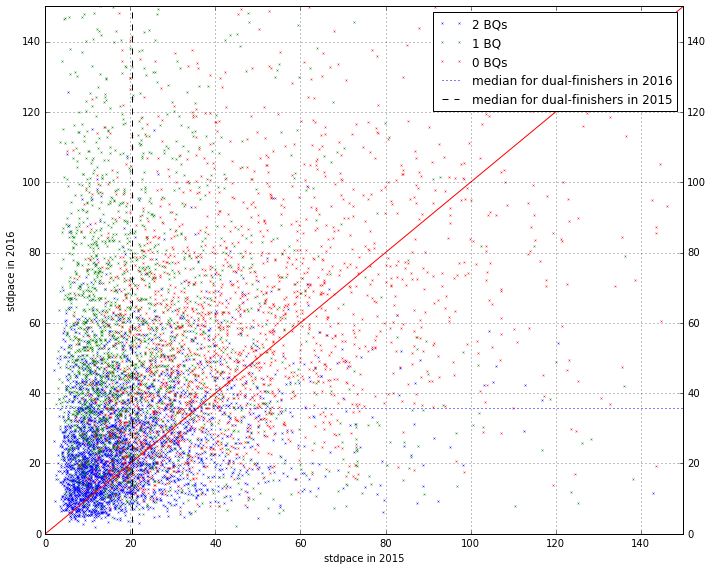

In [83]:
# stdpace vs stdpace
compare['num_BQs'] = compare.BQ_x + compare.BQ_y

plotthis = True
if plotthis == True:
    fig, ax = plt.subplots(1,1, figsize=(10,8))

    plotx = compare.query("num_BQs==2")['stdpace_x']
    ploty = compare.query("num_BQs==2")['stdpace_y']
    ax.plot(plotx,ploty, 'bx', aa=True, markersize=2, label='2 BQs', alpha=0.8)
    
    plotx = compare.query("num_BQs==1")['stdpace_x']
    ploty = compare.query("num_BQs==1")['stdpace_y']
    ax.plot(plotx,ploty, 'gx', aa=True, markersize=2, label='1 BQ', alpha=0.8)    

    plotx = compare.query("num_BQs==0")['stdpace_x']
    ploty = compare.query("num_BQs==0")['stdpace_y']
    ax.plot(plotx,ploty, 'rx', aa=True, markersize=2, label='0 BQs', alpha=0.8)
    ax.plot([0,1000], [0,1000], 'r-')

    plt.xlabel("stdpace in 2015")
    plt.ylabel("stdpace in 2016")
    xlim_range = [0, 150]
    ylim_range = xlim_range
    plt.xlim(xlim_range)
    plt.ylim(ylim_range)
    plt.axhline(compare.stdpace_y.median(), color='b',linestyle=':', label='median for dual-finishers in 2016')
    plt.axvline(compare.stdpace_x.median(), color='k',linestyle='--', label='median for dual-finishers in 2015')
    ax.tick_params(labeltop=False, labelright=True)
    plt.legend(loc='best')
    plt.grid(axis='both')
    plt.tight_layout()
    plt.show()

Given our blog posts about marathon pacing and the metric stdpace, which is a measure of how evenly a runner paces a marathon from start to finish, it shouldn't surprise the reader that those with low stdpace values for both years were the ones who BQed more often.

We've limited the axes to a max of 150, but there are certainly points that fall outside of that range.

It shouldn't surprise anyone that more points lie above the red line than below, since hotter weather will cause people to slow down (and increase stdpace values).

In [84]:
stop_here

NameError: name 'stop_here' is not defined